In [7]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import rasterio
import imageio
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont 
import rasterio.mask
from shapely.geometry import box
import geopandas as gpd
from pyproj import Transformer
import time
import shapely
import re
import datetime
import string
import geopandas
from IPython.display import display, clear_output, HTML
from IPython.display import Image as IPythonImage
import random
from scipy import stats
from scipy.ndimage import gaussian_filter1d
import matplotlib.dates as mdates

<b> JUPYTER NOTEBOOK: </b>
Exploring the structure of a NetCDF file w/ variable length arrays

![alt text](https://s3.amazonaws.com/hr-challenge-images/14507/1476906485-2c93045320-variable-length-arrays.png)

For each lake, I have variable length (vlen) arrays of all my ice cover observations. Vlen data type can be constructed from ints, floats, or any other python type.

~ ~ ~ ~ ~ ~ ~

The NCDump command below is a quick way to output all the variables in a NetCDF file and show the overall file structure.  

![alt text](https://miro.medium.com/v2/resize:fit:720/format:webp/1*p_i85nbMqMQAgTZ_4aexhA.png)

Reading below, the vlen_ types are just my variable types for vlen arrays

The lake dimension is the structure of my dataframe-- each lake in the "lake" dimension has a specific ID (I read these in from ALPOD) which lets me quickly add data based on where the ALPOD shapefile intersects with satellite imagery. The "lake" dimension actually was initiated with unlimited size, but I currently have 43929 entries for individual lakes calculated from my time series data. Usually dimensions are time and lat/lon, but since I wanted
my data organized by lake, I structured my dimensions around the ALPOD list IDs instead of usual spatiotemporal axes.

The other variables like lake_id, study_site, etc. are just normal variables associated with each lake. NetCDF can have variables of all the normal python types.  You can see these all have size of the (lake) dimension since each lake has each of these associated variables. I am working on adding another array variable contraining my red band rasters to the netcdf, so that each lake ID also contains vlen arrays of all the actual Surface Reflectance pixel observations recorded.

In [12]:
# Run ncdump command and capture the output
output = !ncdump -h "C:\Users\nj142\Desktop\lake_ice_time_series.nc"

# Join the output lines into a single string
output_text = "\n".join(output)

# Display the full output as preformatted text
display(HTML(f"<pre>{output_text}</pre>"))

In [10]:
# Set your NetCDF fileopath here
netcdf_path = r"D:\\planetscope_lake_ice\\Data\\Output\\lake_ice_time_series.nc"

In [4]:
""" This script organizes the dataset by # of observations, and prints out the area for the 20 lakes which have the densest time series."""
# Open the NetCDF file
with nc.Dataset(netcdf_path, 'r') as ncfile:
    # Get lake IDs and observation counts
    lake_ids = ncfile.variables['lake_id'][:]
    observation_counts = ncfile.variables['obs_count'][:]
    areas = ncfile.variables['area'][:]
    study_sites = ncfile.variables['study_site'][:]

# Create a DataFrame
df = pd.DataFrame({
    'Lake ID': lake_ids,
    'Number of Observations': observation_counts,
    'Area': areas,
    'Study Site': study_sites
})

# Sort by number of observations in descending order
top_lakes = df.sort_values('Number of Observations', ascending=False).head(20)

print("Top 20 Lakes by Number of Observations:")
print(top_lakes.to_string(index=False))

# Calculate some statistics
total_lakes = len(lake_ids)
total_observations = observation_counts.sum()

print(f"\nTotal Lakes: {total_lakes}")
print(f"Total Observations: {total_observations}")
print(f"Average Observations per Lake: {total_observations/total_lakes:.2f}")

Top 20 Lakes by Number of Observations:
 Lake ID  Number of Observations         Area Study Site
  445139                      92 21263.259766        YKD
  446606                      92  1064.355591        YKD
  160554                      92 22175.203125        YKD
  160785                      91  2319.127197        YKD
  161092                      91 10533.465820        YKD
  446481                      91  1354.508911        YKD
  446628                      91  1451.431274        YKD
  446577                      91  1838.399658        YKD
  446384                      91  1934.871338        YKD
  446538                      91 15045.232422        YKD
  160553                      91  6377.226562        YKD
  160316                      90  2077.354736        YKD
  161195                      90 10147.074219        YKD
  446590                      90 47361.191406        YKD
  161085                      90 28216.783203        YKD
  446337                      90 10061.033203   

In [12]:
"""This block is the function to print all data for a single lake, executed in the cell below."""

def check_lake_data(netcdf_path, lake_id=None):
    """
    Read and display lake data from a NetCDF file with VLEN data format.  

    Parameters:
    -----------
    netcdf_path : str
        Path to the NetCDF file.
    lake_id : int, optional
        Specific lake ID to inspect. If None, lists all lake IDs.
    """
    with nc.Dataset(netcdf_path, 'r') as ncfile:
        # Get all lake IDs
        lake_ids = ncfile.variables['lake_id'][:]
        
        if lake_id is None:
            print("Available Lake IDs:")
            print(lake_ids)
            return
        
        # Find the index of the specified lake
        matches = np.where(lake_ids == lake_id)[0]
        if len(matches) == 0:
            print(f"Lake ID {lake_id} not found in the dataset.")
            return
        lake_index = matches[0]
        
        # Print lake-level metadata
        print(f"\nLake ID: {lake_id}")
        print(f"Area: {ncfile.variables['area'][lake_index]:.2f} sq meters")
        # If available, print additional metadata
        if 'perimeter' in ncfile.variables:
            print(f"Perimeter: {ncfile.variables['perimeter'][lake_index]:.2f} meters")
        if 'study_site' in ncfile.variables:
            # Handle study_site, which might be stored as bytes or string
            study_site = ncfile.variables['study_site'][lake_index]
            if isinstance(study_site, bytes):
                study_site = study_site.decode('utf-8')
            print(f"Study Site: {study_site}")
        print(f"Total Pixels: {ncfile.variables['total_pixels'][lake_index]}")
        print(f"Image Names: {ncfile.variables['image_names_csv'][lake_index]}")
        
        # Use obs_count for the number of observations
        obs_count = ncfile.variables['obs_count'][lake_index]
        print(f"Number of Observations: {obs_count}")
        
        if obs_count == 0:
            print("No observations found for this lake.")
            return
        
        # For VLEN arrays, each element is an array of varying length
        # We need to explicitly get each VLEN array for the current lake
        
        # Build the data dictionary for observations
        data = {}
        
        # For 'unix_time' (stored as Unix timestamps)
        timestamps = ncfile.variables['unix_time'][lake_index]
        data['Date (Unix)'] = timestamps
        
        # For 'prefix': it's likely a single string, not a comma-separated list
        prefix = ncfile.variables['image_names_csv'][lake_index]
        if isinstance(prefix, bytes):
            prefix = prefix.decode('utf-8')
        
        # For all other numeric observation variables with VLEN format
        for var_name in ['usable_pixels', 'clear_percent', 'ice_pixels', 
                 'ice_percent', 'snow_pixels', 'snow_percent', 
                 'water_pixels', 'water_percent', "full_image_cloud_percent"]:
            if var_name in ncfile.variables:
                values = ncfile.variables[var_name][lake_index]
        
        # Handle short 'full_image_cloud_percent'
        if var_name == "full_image_cloud_percent":
            if len(values) < obs_count:
                print(f"Padding {var_name} from {len(values)} to {obs_count} with zeros.")
                pad_length = obs_count - len(values)
                values = np.concatenate([values, np.zeros(pad_length, dtype=values.dtype)])
        
        data[var_name] = values

        
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        # Add human-readable datetime to the end
        df['unix_time'] = df['Date (Unix)'].apply(
            lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')
        )
        
        print("\nOBSERVATIONS ({}):".format(obs_count))
        print(df.to_string(index=False))

In [ ]:
# CHOOSE YOUR LAKE NUMBER HERE
lake_id =  162020

# Runs above script to print out data for the requested lake ID (ID sourced from ALPOD)
check_lake_data(netcdf_path, lake_id)


Lake ID: 162020
Area: 2464.75 sq meters
Perimeter: 244.78 meters
Study Site: YKD
Total Pixels: 272
Image Names: 20190602_194317_0f4b,20190605_213954_1006,20190606_214628_0f12,20190608_194222_0f36,20190608_214328_100a,20190611_214608_0f35,20190612_214543_100a,20190614_214615_0f31,20200417_205405_03_1069,20200419_221511_90_1060,20200518_204701_26_106e,20200611_184304_1050,20200612_214858_100a,20200613_205149_49_1069,20200613_214854_0f28,20200613_214855_0f28,20210420_221242_49_2407,20210426_211740_03_2435,20210426_211742_51_2435,20210430_203053_17_106a,20220501_211214_16_2431,20220503_220225_57_227c,20220517_210716_18_2442,20220517_210718_46_2442,20220604_214157_30_249d,20220605_211042_99_2435,20220606_214615_49_248c,20220607_214635_36_2470,20220609_214151_08_2490,20220610_210915_97_2429,20220610_215511_80_2402,20220610_215514_09_2402,20220611_211502_74_2439,20220611_211505_04_2439,20220611_214601_09_2488,20220612_214647_40_247b,20220612_214649_72_247b,20220615_214330_71_247a,20230528_21

In [6]:
"""This block is the function to turn the data above into a time series graph-- WITHOUT FILTERING!!  Filtering version below."""

def plot_time_series_for_lake(netcdf_path, lake_id):
    """
    For a given lake_id, read the VLEN NetCDF file, group observations by year,
    and plot time series for ice, snow, and water percentages for each year with data.
    
    Parameters:
    -----------
    netcdf_path : str
        Path to the NetCDF file.
    lake_id : int
        The lake ID to plot data for.
    """
    with nc.Dataset(netcdf_path, 'r') as ncfile:
        # Find the index of the specified lake
        lake_ids = ncfile.variables['lake_id'][:]
        matches = np.where(lake_ids == lake_id)[0]
        if len(matches) == 0:
            print(f"Lake ID {lake_id} not found in the dataset.")
            return
        lake_index = matches[0]
        
        # Get number of observations for the lake
        obs_count = ncfile.variables['obs_count'][lake_index]
        if obs_count == 0:
            print(f"No observations found for lake ID {lake_id}.")
            return

        # Extract Unix timestamps and convert to datetime objects
        # (Assumes that the variable 'unix_time' is stored as a VLEN array of Unix timestamps)
        time_data = ncfile.variables['unix_time'][lake_index]
        datetimes = [datetime.datetime.fromtimestamp(ts) for ts in time_data]
        
        # Extract percentage variables for ice, snow, and water.
        # These variables are expected to be arrays of the same length as time_data.
        ice_percent = ncfile.variables['ice_percent'][lake_index]
        snow_percent = ncfile.variables['snow_percent'][lake_index]
        water_percent = ncfile.variables['water_percent'][lake_index]
        
        # Create a DataFrame with the data and add a year column
        df = pd.DataFrame({
            'datetime': datetimes,
            'ice_percent': ice_percent,
            'snow_percent': snow_percent,
            'water_percent': water_percent
        })
        df['year'] = df['datetime'].dt.year

    # Define colors for the plots
    ice_color   = '#87CEEB'
    snow_color  = '#FF8C00'
    water_color = '#0000FF'

    # Get unique years with observations
    unique_years = sorted(df['year'].unique())
    
    # Loop over each year and plot the time series if data exists for that year
    for year in unique_years:
        df_year = df[df['year'] == year]
        if df_year.empty:
            continue
        
        plt.figure(figsize=(10, 6))
        plt.plot(df_year['datetime'], df_year['ice_percent'], label='Ice %', 
                 color=ice_color, marker='o')
        plt.plot(df_year['datetime'], df_year['snow_percent'], label='Snow %', 
                 color=snow_color, marker='o')
        plt.plot(df_year['datetime'], df_year['water_percent'], label='Water %', 
                 color=water_color, marker='o')
        plt.xlabel('Date')
        plt.ylabel('Percentage')
        plt.title(f"Lake {lake_id} - Time Series for Year {year}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [11]:
""" Output breakup time series (calculated 75% water) as a CSV for all observations """

def aggregate_daily_observations(df):
    """Aggregate multiple observations per day by selecting the observation with highest water %"""
    df['date'] = df['datetime'].dt.date

    # Group by date and select observation with highest water percentage
    daily_data = []
    for date, group in df.groupby('date'):
        max_water_idx = group['water_percent'].idxmax()
        best_obs = group.loc[max_water_idx]
        datetime_repr = best_obs['datetime'].replace(hour=12, minute=0, second=0, microsecond=0)

        daily_data.append({
            'datetime': datetime_repr,
            'date': date,
            'ice_percent': best_obs['ice_percent'],
            'snow_percent': best_obs['snow_percent'],
            'water_percent': best_obs['water_percent']
        })

    return pd.DataFrame(daily_data).sort_values('datetime').reset_index(drop=True)

def classify_pixel_validity(df_daily):
    df_daily['pixel_valid'] = True

    # Rule 1: All three classes are low
    for i, row in df_daily.iterrows():
        if row['ice_percent'] < 10 and row['snow_percent'] < 10 and row['water_percent'] < 10:
            df_daily.loc[i, 'pixel_valid'] = False

    # Rule 2: More than one category at 100%
    for i, row in df_daily.iterrows():
        count_100 = sum([
            row['ice_percent'] == 100,
            row['snow_percent'] == 100,
            row['water_percent'] == 100
        ])
        if count_100 > 1:
            df_daily.loc[i, 'pixel_valid'] = False

    # Rule 3: Outlier days where the value jumps UP and then drops back down
    if len(df_daily) >= 3:
        for i in range(1, len(df_daily) - 1):
            if not df_daily.loc[df_daily.index[i - 1], 'pixel_valid']:
                continue
            if not df_daily.loc[df_daily.index[i + 1], 'pixel_valid']:
                continue

            for class_name in ['ice_percent', 'snow_percent']:
                prev_val = df_daily.loc[df_daily.index[i - 1], class_name]
                curr_val = df_daily.loc[df_daily.index[i], class_name]
                next_val = df_daily.loc[df_daily.index[i + 1], class_name]

                jump_up = (curr_val - prev_val) > 75
                jump_down = (curr_val - next_val) > 75

                if jump_up and jump_down:
                    if abs(prev_val - next_val) < abs(curr_val - prev_val):
                        df_daily.loc[df_daily.index[i], 'pixel_valid'] = False
                        break

    # Rule 4: First valid water >= 75%
    first_high_water_idx = None
    for i, row in df_daily.iterrows():
        if row['pixel_valid'] and row['water_percent'] >= 75:
            first_high_water_idx = row.name
            break

    # Rule 5: After first high water, all water must be >= 95%
    if first_high_water_idx is not None:
        start_pos = df_daily.index.get_loc(first_high_water_idx)
        for i in range(start_pos + 1, len(df_daily)):
            idx = df_daily.index[i]
            if df_daily.loc[idx, 'water_percent'] < 95:
                df_daily.loc[idx, 'pixel_valid'] = False

    return df_daily

def find_breakup_date(df_sorted):
    """
    Estimate breakup date as the interpolated point where water_percent crosses 75%
    between two valid consecutive days. Error bounds are the time gaps to the adjacent points.
    """
    df_daily = aggregate_daily_observations(df_sorted)
    df_classified = classify_pixel_validity(df_daily)
    valid_df = df_classified[df_classified['pixel_valid']].reset_index(drop=True)

    for i in range(len(valid_df) - 1):
        curr = valid_df.iloc[i]
        next_ = valid_df.iloc[i + 1]

        wp1 = curr['water_percent']
        wp2 = next_['water_percent']

        if wp1 <= 75 < wp2:
            if wp2 == wp1:
                continue  # Avoid division by zero

            t1 = curr['datetime']
            t2 = next_['datetime']
            frac = (75 - wp1) / (wp2 - wp1)
            breakup_date = t1 + (t2 - t1) * frac

            lower_bound_days = round((breakup_date - t1).total_seconds() / 86400)
            upper_bound_days = round((t2 - breakup_date).total_seconds() / 86400)

            return breakup_date, lower_bound_days, upper_bound_days, "WATER interpolated @75%"

    return None, None, None, "NO CROSSING FOUND"

def calculate_breakup_stats_all_lakes(netcdf_path, output_path, cloud_cover_threshold=0):
    results = []

    target_lake_ids = set([446055,446065,446078,446081,446097,446115,446146,446147,446159,446160,446161,446166,446177,446208,446223,446227,446232,446236,446289,446325,446328,446329,446337,446348,446365,446375,446382,446384,446388,446417,446458,446466,446475,446481,446538,446577,446590,446606,446617,44662,446626,446628,446638,446658,446671,446748,446778,446797,446838,446856,446881,446888,446891,446895,446935,446945,447029,447135,447163,447180,447292,447318,447356,447420,447483,447521,447550,447580,447617,447626,447647,447664,447693,447695,447736])

    with nc.Dataset(netcdf_path, 'r') as ncfile:
        lake_ids = ncfile.variables['lake_id'][:]
        study_sites = ncfile.variables['study_site'][:]
        areas = ncfile.variables['area'][:]
        cloud_cover_percents = ncfile.variables['full_image_cloud_percent'][:]
        total_lakes = len(lake_ids)

        print(f"Processing {total_lakes} lakes with cloud cover threshold: {cloud_cover_threshold}%...")

        for lake_index in range(total_lakes):
            lake_id = lake_ids[lake_index]

            if lake_id not in target_lake_ids:
                continue  # Skip this lake if it's not in the specified list

            study_site = study_sites[lake_index]
            area = areas[lake_index]
            cloud_cover_percent = cloud_cover_percents[lake_index]
            obs_count = ncfile.variables['obs_count'][lake_index]

            result_row = {
                'lake_id': lake_id,
                'study_site': study_site,
                'area': area,
                'breakup_date': None,
                'error_days_positive': None,
                'error_days_negative': None,
                'valid_observations': 0,
                'invalid_observations': 0,
                'detection_method': 'INVALID TIME SERIES'
            }

            if obs_count == 0:
                result_row['invalid_observations'] = 0
                results.append(result_row)
                continue

            try:
                time_data = ncfile.variables['unix_time'][lake_index]
                ice_percent = ncfile.variables['ice_percent'][lake_index]
                snow_percent = ncfile.variables['snow_percent'][lake_index]
                water_percent = ncfile.variables['water_percent'][lake_index]
                image_cloud_cover = ncfile.variables['full_image_cloud_percent'][lake_index]
                # Pad full_image_cloud_percent if too short
                if len(image_cloud_cover) < obs_count:
                    pad_length = obs_count - len(image_cloud_cover)
                    print(f"Lake {lake_id}: Padding full_image_cloud_percent from {len(image_cloud_cover)} to {obs_count}")
                    image_cloud_cover = np.concatenate([image_cloud_cover, np.zeros(pad_length, dtype=image_cloud_cover.dtype)])


                datetimes = [datetime.datetime.fromtimestamp(ts) for ts in time_data]

                df_full = pd.DataFrame({
                    'datetime': datetimes,
                    'ice_percent': ice_percent,
                    'snow_percent': snow_percent,
                    'water_percent': water_percent,
                    'cloud_cover_percent': image_cloud_cover
                })

                df_full = df_full[df_full['cloud_cover_percent'] <= cloud_cover_threshold].copy()

                if df_full.empty:
                    result_row['invalid_observations'] = obs_count
                    result_row['detection_method'] = f'ALL IMAGES CLOUD COVER >{cloud_cover_threshold}%'
                    results.append(result_row)
                    continue

                df_full['year'] = df_full['datetime'].dt.year
                df_full['month'] = df_full['datetime'].dt.month
                df_2022 = df_full[(df_full['year'] == 2022) & (df_full['month'].between(4, 6))].copy()

                if df_2022.empty:
                    result_row['invalid_observations'] = obs_count
                    results.append(result_row)
                    continue

                df_2022 = df_2022.sort_values('datetime').reset_index(drop=True)
                df_daily_check = aggregate_daily_observations(df_2022)

                first_row = df_daily_check.iloc[0]
                if not (first_row['ice_percent'] > first_row['water_percent'] or 
                        first_row['snow_percent'] > first_row['water_percent']):
                    result_row['valid_observations'] = len(df_daily_check)
                    result_row['invalid_observations'] = obs_count - len(df_2022)
                    result_row['detection_method'] = 'INVALID TIME SERIES'
                    results.append(result_row)
                    continue

                breakup_date, days_before, days_after, detection_method = find_breakup_date(df_2022)

                result_row['valid_observations'] = len(df_daily_check)
                result_row['invalid_observations'] = obs_count - len(df_2022)
                result_row['detection_method'] = detection_method

                if breakup_date is not None:
                    result_row['breakup_date'] = breakup_date.strftime('%Y-%m-%d')  # Or .isoformat() if you prefer
                    result_row['error_days_positive'] = days_after
                    result_row['error_days_negative'] = days_before

                results.append(result_row)

            except Exception as e:
                print(f"Error processing lake {lake_id}: {e}")
                result_row['invalid_observations'] = obs_count
                results.append(result_row)
                continue

            if (lake_index + 1) % 100 == 0:
                print(f"Processed {lake_index + 1}/{total_lakes} lakes")

    df_results = pd.DataFrame(results)
    df_results.to_excel(output_path, index=False)
    print(f"Results saved to {output_path}")
    print(f"Total lakes processed: {len(results)}")

    valid_breakup = df_results[df_results['breakup_date'].notna()]
    water_detected = df_results[df_results['detection_method'].str.contains('WATER')]
    invalid_series = df_results[df_results['detection_method'] == 'INVALID TIME SERIES']
    cloud_filtered = df_results[df_results['detection_method'] == f'ALL IMAGES CLOUD COVER >{cloud_cover_threshold}%']

    print(f"\nSummary:")
    print(f"Valid breakup dates found: {len(valid_breakup)}")
    print(f"Water >75% detected: {len(water_detected)}")
    print(f"Invalid time series: {len(invalid_series)}")
    print(f"Filtered due to cloud cover >{cloud_cover_threshold}%: {len(cloud_filtered)}")

    return df_results

In [20]:
# Run the above ^^^
df_stats = calculate_breakup_stats_all_lakes("D:\\planetscope_lake_ice\\Data\\Output\\lake_ice_time_series.nc", 'D:\\planetscope_lake_ice\\Data\\Output\\breakup_2022_stats_ykd.xlsx')

Processing 76469 lakes with cloud cover threshold: 0%...
Lake 446055: Padding full_image_cloud_percent from 51 to 91
Lake 446097: Padding full_image_cloud_percent from 49 to 89
Lake 446115: Padding full_image_cloud_percent from 49 to 87
Lake 446208: Padding full_image_cloud_percent from 52 to 92
Lake 446232: Padding full_image_cloud_percent from 50 to 90
Lake 446328: Padding full_image_cloud_percent from 50 to 89
Processed 44400/76469 lakes
Lake 446337: Padding full_image_cloud_percent from 56 to 96
Lake 446388: Padding full_image_cloud_percent from 48 to 86
Lake 446466: Padding full_image_cloud_percent from 53 to 94
Lake 446481: Padding full_image_cloud_percent from 55 to 97
Lake 446538: Padding full_image_cloud_percent from 54 to 95
Lake 446590: Padding full_image_cloud_percent from 53 to 94
Lake 446606: Padding full_image_cloud_percent from 55 to 97
Lake 446617: Padding full_image_cloud_percent from 53 to 94
Lake 446626: Padding full_image_cloud_percent from 49 to 89
Lake 446638: Pa

In [21]:
""" Filter the CSV above to only contain those lakes with at least N observations, output new CSV as GIS friendly csv file"""
# Load the data
file_path = r"D:\planetscope_lake_ice\Data\Output\breakup_2022_stats_ykd.xlsx"
df = pd.read_excel(file_path)

# Convert breakup_date to datetime
df['breakup_date'] = pd.to_datetime(df['breakup_date'], errors='coerce')

# Define valid data condition
sufficient_observations = df['valid_observations'] >= 1
valid_data = df[sufficient_observations].copy()

# Filter dates within desired range
start_date = datetime.datetime(2022, 4, 1)
end_date = datetime.datetime(2022, 6, 30)
in_range = valid_data['breakup_date'].between(start_date, end_date)

# Format breakup_date as GIS-style MMDD
valid_data.loc[in_range, 'GIS_date'] = valid_data.loc[in_range, 'breakup_date'].dt.strftime('%m%d')

# Drop any rows that are out of range or have no GIS_date
df_filtered = valid_data[~valid_data['GIS_date'].isna()]

# Save to CSV
csv_path = file_path.replace("\\breakup_2022_stats_", "\\GIS_breakup_2022_stats_").replace('.xlsx', '.csv')
df_filtered.to_csv(csv_path, index=False)

print(f"Filtered CSV saved to:\n{csv_path}")

Filtered CSV saved to:
D:\planetscope_lake_ice\Data\Output\GIS_breakup_2022_stats_ykd.csv


Loading data from CSV files...
Original PlanetScope lakes: 74
Original Sentinel-2 lakes: 8333
Common lakes between datasets: 74
Filtered PlanetScope lakes (common only): 74
Filtered Sentinel-2 lakes (common only): 74


C:\Users\nj142\AppData\Local\Temp\ipykernel_24896\2815599713.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


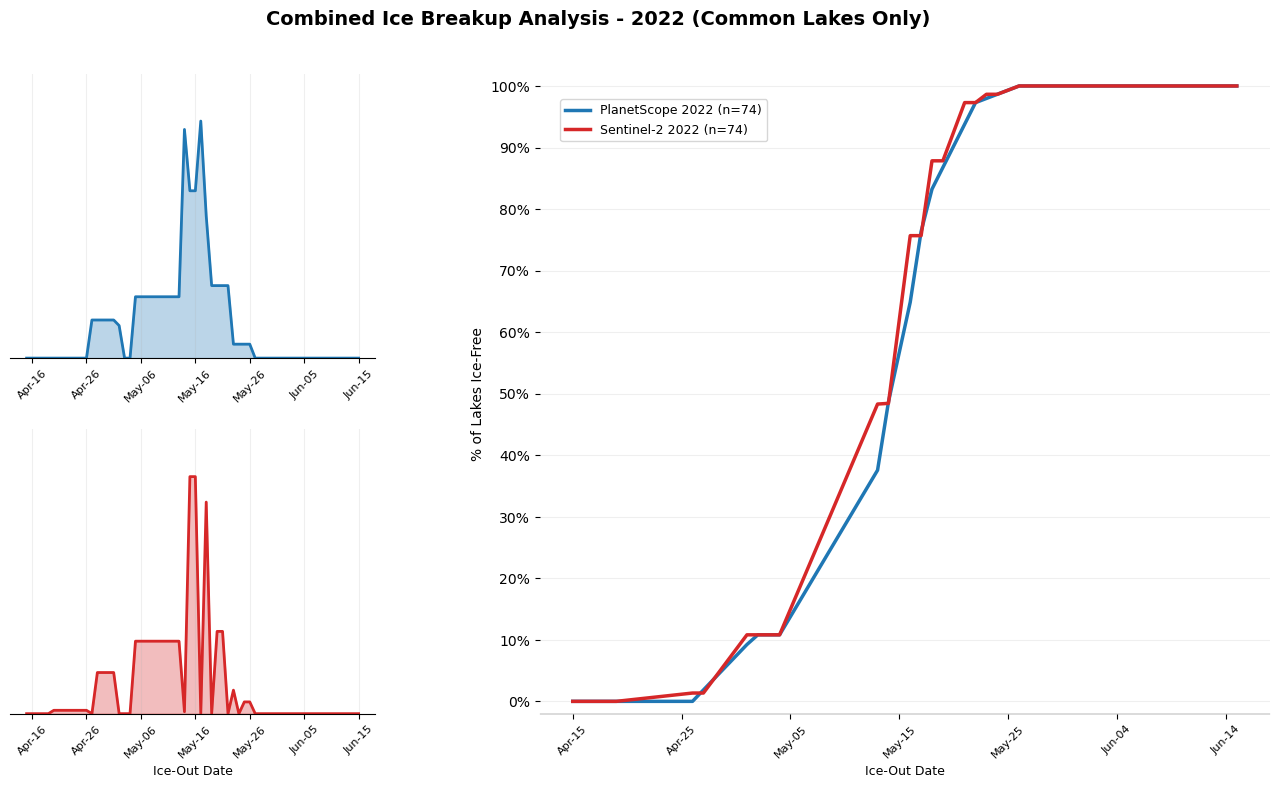


Plot created for 2022!
PlanetScope: 74 lakes (common lakes only)
Sentinel-2: 74 lakes (common lakes only)


In [22]:
"""Graph the S2 vs PlanetScope time series for a given year"""
# --------------------
# Configuration
# --------------------
year = 2022
date_bin_width = 1
start_month_day = ("04-15", "06-15")
dummy_year = 2000  # Used for aligning right-hand cumulative plot

# --------------------
# Load data
# --------------------
# Load data from CSV files
print("Loading data from CSV files...")
planetscope_csv_path = r"C:\Users\nj142\Desktop\2022-PlanetScope\5x5KM 2022 YKD Test with 75 lakes.csv"
sentinel2_csv_path = r"C:\Users\nj142\Desktop\2019-2025-S2\breakup_2022_stats_ykd.csv"

df_ps = pd.read_csv(planetscope_csv_path)
df_ps['breakup_date'] = pd.to_datetime(df_ps['breakup_date'])

df_s2 = pd.read_csv(sentinel2_csv_path)
df_s2['breakup_date'] = pd.to_datetime(df_s2['breakup_date'])
df_s2 = df_s2[df_s2['breakup_date'].dt.year == year].copy()

# --------------------
# Filter BOTH datasets to only include lakes present in BOTH datasets
# --------------------
# Get the unique lake IDs from both datasets
ps_lake_ids = set(df_ps['lake_id'])
s2_lake_ids = set(df_s2['lake_id'])

# Find the intersection - lakes that appear in both datasets
common_lake_ids = ps_lake_ids.intersection(s2_lake_ids)

# Filter both datasets to only include the common lakes
df_ps_filtered = df_ps[df_ps['lake_id'].isin(common_lake_ids)].copy()
df_s2_filtered = df_s2[df_s2['lake_id'].isin(common_lake_ids)].copy()

print(f"Original PlanetScope lakes: {len(df_ps)}")
print(f"Original Sentinel-2 lakes: {len(df_s2)}")
print(f"Common lakes between datasets: {len(common_lake_ids)}")
print(f"Filtered PlanetScope lakes (common only): {len(df_ps_filtered)}")
print(f"Filtered Sentinel-2 lakes (common only): {len(df_s2_filtered)}")

# --------------------
# Plotting function (unchanged)
# --------------------
def create_combined_breakup_plot(df_ps, df_s2, year):
    """Create breakup analysis plot comparing PlanetScope and Sentinel-2 data"""
    
    if df_ps.empty and df_s2.empty:
        print("No valid breakup data found for either dataset")
        return
    
    # Color scheme
    ps_color = '#1f77b4'
    s2_color = '#d62728'
    
    # Date ranges
    shared_start_date = pd.Timestamp(f"{dummy_year}-{start_month_day[0]}")
    shared_end_date = pd.Timestamp(f"{dummy_year}-{start_month_day[1]}")
    shared_date_range = pd.date_range(start=shared_start_date, end=shared_end_date, freq=f'{date_bin_width}D')
    
    start_date = pd.Timestamp(f"{year}-{start_month_day[0]}")
    end_date = pd.Timestamp(f"{year}-{start_month_day[1]}")
    date_range = pd.date_range(start=start_date, end=end_date, freq=f'{date_bin_width}D')
    
    # Create figure and subplots
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.25)
    
    # Left side subplots for probability distributions
    ax_ps = fig.add_subplot(gs[0, 0])
    ax_s2 = fig.add_subplot(gs[1, 0], sharex=ax_ps)
    
    # PlanetScope probability distribution
    if not df_ps.empty:
        probs_ps = np.zeros(len(date_range))
        for _, row in df_ps.iterrows():
            low = row['breakup_date'] - pd.Timedelta(days=row['error_days_negative'])
            high = row['breakup_date'] + pd.Timedelta(days=row['error_days_positive'])
            mask = (date_range >= low) & (date_range <= high)
            if mask.sum() > 0:
                probs_ps[mask] += 1 / (mask.sum() * len(df_ps))
        
        smoothed_ps = gaussian_filter1d(probs_ps, sigma=0.0001)
        ax_ps.plot(date_range, smoothed_ps, color=ps_color, linewidth=2)
        ax_ps.fill_between(date_range, smoothed_ps, color=ps_color, alpha=0.3)
        ax_ps.set_ylabel("PlanetScope", fontsize=9, color=ps_color)
        ax_ps.get_yaxis().set_visible(False)
        ax_ps.spines[['top', 'right', 'left']].set_visible(False)
        ax_ps.grid(True, alpha=0.2, axis='x')
        ax_ps.set_ylim(0, smoothed_ps.max() * 1.2)
    
    # Sentinel-2 probability distribution
    if not df_s2.empty:
        probs_s2 = np.zeros(len(date_range))
        for _, row in df_s2.iterrows():
            low = row['breakup_date'] - pd.Timedelta(days=row['error_days_negative'])
            high = row['breakup_date'] + pd.Timedelta(days=row['error_days_positive'])
            mask = (date_range >= low) & (date_range <= high)
            if mask.sum() > 0:
                probs_s2[mask] += 1 / (mask.sum() * len(df_s2))
        
        smoothed_s2 = gaussian_filter1d(probs_s2, sigma=0.0001)
        ax_s2.plot(date_range, smoothed_s2, color=s2_color, linewidth=2)
        ax_s2.fill_between(date_range, smoothed_s2, color=s2_color, alpha=0.3)
        ax_s2.set_ylabel("Sentinel-2", fontsize=9, color=s2_color)
        ax_s2.get_yaxis().set_visible(False)
        ax_s2.spines[['top', 'right', 'left']].set_visible(False)
        ax_s2.grid(True, alpha=0.2, axis='x')
        ax_s2.set_ylim(0, smoothed_s2.max() * 1.2)
        ax_s2.set_xlabel("Ice-Out Date", fontsize=9)
    
    # Format x-axis for left subplots
    for ax in [ax_ps, ax_s2]:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, fontsize=8)
    
    # Right side cumulative plot
    ax_right = fig.add_subplot(gs[:, 1])
    ax_right.set_ylabel('% of Lakes Ice-Free', fontsize=10)
    ax_right.set_xlabel("Ice-Out Date", fontsize=9)
    ax_right.set_ylim(-2, 102)
    ax_right.grid(True, alpha=0.2, axis='y')
    ax_right.spines[['top', 'right', 'left']].set_visible(False)
    ax_right.spines['bottom'].set_linewidth(0.2)
    ax_right.yaxis.set_major_locator(plt.MultipleLocator(10))
    ax_right.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}%'))
    ax_right.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    ax_right.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    plt.setp(ax_right.xaxis.get_majorticklabels(), rotation=45, fontsize=8)
    
    # PlanetScope cumulative curve
    if not df_ps.empty:
        cumulative_probs_ps = np.zeros(len(shared_date_range))
        for _, row in df_ps.iterrows():
            base_date = row['breakup_date'].replace(year=dummy_year)
            low = base_date - pd.Timedelta(days=row['error_days_negative'])
            high = base_date + pd.Timedelta(days=row['error_days_positive'])
            prob_mass = np.zeros(len(shared_date_range))
            mask = (shared_date_range >= low) & (shared_date_range <= high)
            if mask.sum() > 0:
                prob_mass[mask] = 1 / mask.sum()
            cumulative_probs_ps += np.cumsum(prob_mass)
        
        cumulative_pct_ps = (cumulative_probs_ps / len(df_ps)) * 100
        ax_right.plot(shared_date_range, cumulative_pct_ps, color=ps_color, linewidth=2.5,
                      label=f'PlanetScope {year} (n={len(df_ps)})')
    
    # Sentinel-2 cumulative curve
    if not df_s2.empty:
        cumulative_probs_s2 = np.zeros(len(shared_date_range))
        for _, row in df_s2.iterrows():
            base_date = row['breakup_date'].replace(year=dummy_year)
            low = base_date - pd.Timedelta(days=row['error_days_negative'])
            high = base_date + pd.Timedelta(days=row['error_days_positive'])
            prob_mass = np.zeros(len(shared_date_range))
            mask = (shared_date_range >= low) & (shared_date_range <= high)
            if mask.sum() > 0:
                prob_mass[mask] = 1 / mask.sum()
            cumulative_probs_s2 += np.cumsum(prob_mass)
        
        cumulative_pct_s2 = (cumulative_probs_s2 / len(df_s2)) * 100
        ax_right.plot(shared_date_range, cumulative_pct_s2, color=s2_color, linewidth=2.5,
                      label=f'Sentinel-2 {year} (n={len(df_s2)})')
    
    # Add legend and formatting
    ax_right.legend(loc='upper left', fontsize=9, frameon=True, fancybox=True,
                    bbox_to_anchor=(0.02, 0.97))
    
    # Final layout adjustments
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.08, right=0.98)
    fig.suptitle(f'Combined Ice Breakup Analysis - {year} (Common Lakes Only)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nPlot created for {year}!")
    if not df_ps.empty:
        print(f"PlanetScope: {len(df_ps)} lakes (common lakes only)")
    if not df_s2.empty:
        print(f"Sentinel-2: {len(df_s2)} lakes (common lakes only)")

# --------------------
# Create the plot with filtered data
# --------------------
create_combined_breakup_plot(df_ps_filtered, df_s2_filtered, year)

In [ ]:
""" Plot a single PlanetScope time series for a given lake ID (MAKE SURE YOU RAN THE CODE ABOVE TO DEFINE FUNCTIONS) """

def plot_single_lake_breakup(netcdf_path, target_lake_id, year):
    """Plot the filtered time series for a single lake ID and year"""
    import datetime
    with nc.Dataset(netcdf_path, 'r') as ncfile:
        lake_ids = ncfile.variables['lake_id'][:]
        
        # Find the index of the target lake ID
        try:
            lake_index = list(lake_ids).index(target_lake_id)
        except ValueError:
            print(f"Lake ID {target_lake_id} not found in dataset")
            return
        
        # Check if lake has observations
        obs_count = ncfile.variables['obs_count'][lake_index]
        if obs_count == 0:
            print(f"Lake {target_lake_id} has no observations")
            return

        # Define colors
        ice_color   = '#87CEEB'
        snow_color  = '#FF8C00'
        water_color = '#0000FF'

        try:
            # Extract data for the target lake
            time_data = ncfile.variables['unix_time'][lake_index]
            datetimes = [datetime.datetime.fromtimestamp(ts) for ts in time_data]
            ice_percent = ncfile.variables['ice_percent'][lake_index]
            snow_percent = ncfile.variables['snow_percent'][lake_index]
            water_percent = ncfile.variables['water_percent'][lake_index]
            
            # Create dataframe
            df_full = pd.DataFrame({
                'datetime': datetimes,
                'ice_percent': ice_percent,
                'snow_percent': snow_percent,
                'water_percent': water_percent
            })
            
            # Filter for the specified year and months (April-June)
            df_full['year'] = df_full['datetime'].dt.year
            df_full['month'] = df_full['datetime'].dt.month
            df_year = df_full[(df_full['year'] == year) & (df_full['month'].between(4, 6))].copy()

            if df_year.empty:
                print(f"No data found for Lake {target_lake_id} in year {year} (April-June)")
                return

            # Check if there are enough unique dates
            if df_year['datetime'].dt.date.nunique() < 5:
                print(f"Lake {target_lake_id} has insufficient data for year {year} (less than 5 unique dates)")
                return

            # Sort by datetime
            df_year = df_year.sort_values('datetime').reset_index(drop=True)
            
            # Aggregate daily observations and classify validity
            df_daily = aggregate_daily_observations(df_year)
            df_classified = classify_pixel_validity(df_daily)
            
            # Check if breakup pattern exists (snow/ice should start higher than water)
            first_row = df_classified.iloc[0]
            if not (first_row['ice_percent'] > first_row['water_percent'] or 
                    first_row['snow_percent'] > first_row['water_percent']):
                print(f"Lake {target_lake_id} in year {year} does not show typical breakup pattern")
            
            # Find breakup date (returns 4 values: breakup_date, days_before, days_after, detection_method)
            breakup_date, days_before, days_after, detection_method = find_breakup_date(df_year)
            
            # Separate valid and invalid points
            valid_points = df_classified[df_classified['pixel_valid']]
            invalid_points = df_classified[~df_classified['pixel_valid']]
            
            # Create the plot
            plt.figure(figsize=(12, 6))
            ax = plt.gca()

            # Plot lines for valid points only
            if not valid_points.empty:
                ax.plot(valid_points['datetime'], valid_points['water_percent'],
                       label='Water %', color=water_color)
                ax.plot(valid_points['datetime'], valid_points['ice_percent'],
                       label='Ice %', color=ice_color)
                ax.plot(valid_points['datetime'], valid_points['snow_percent'],
                       label='Snow %', color=snow_color)

            # Plot all valid points as scatter
            if not valid_points.empty:
                ax.scatter(valid_points['datetime'], valid_points['water_percent'], 
                          color=water_color, marker='o', alpha=0.7)
                ax.scatter(valid_points['datetime'], valid_points['ice_percent'], 
                          color=ice_color, marker='o', alpha=0.7)
                ax.scatter(valid_points['datetime'], valid_points['snow_percent'], 
                          color=snow_color, marker='o', alpha=0.7)

            # Plot invalid points as scatter only (no lines)
            if not invalid_points.empty:
                ax.scatter(invalid_points['datetime'], invalid_points['water_percent'], 
                          color=water_color, marker='o', alpha=0.7)
                ax.scatter(invalid_points['datetime'], invalid_points['ice_percent'], 
                          color=ice_color, marker='o', alpha=0.7)
                ax.scatter(invalid_points['datetime'], invalid_points['snow_percent'], 
                          color=snow_color, marker='o', alpha=0.7)

            # Plot breakup date as vertical line if detected
            if breakup_date is not None:
                ax.axvline(x=breakup_date, color='red', linestyle='--', alpha=0.7, label='Breakup')

            # Format title with breakup information
            if breakup_date is not None:
                breakup_str = breakup_date.strftime('%Y-%m-%d')
                title = f"Lake {target_lake_id} ({year}) | Estimated Breakup: {breakup_str} +{days_after}/-{days_before} ({detection_method})"
            else:
                title = f"Lake {target_lake_id} ({year}) | No breakup detected ({detection_method})"
            
            ax.set_title(title)
            ax.set_xlabel("Date")
            ax.set_ylabel("Percentage")
            ax.legend()
            ax.grid(True)
            
            from matplotlib.dates import DateFormatter, DayLocator

            # Major ticks/labels on 1st, 10th, 20th
            ax.xaxis.set_major_locator(DayLocator(bymonthday=[1, 10, 20]))
            ax.xaxis.set_major_formatter(DateFormatter('%B %d'))

            # Minor ticks/gridlines for every day
            ax.xaxis.set_minor_locator(DayLocator())  # daily ticks

            # Tick styling
            ax.tick_params(axis='x', which='major', rotation=45, labelsize=10)
            ax.tick_params(axis='x', which='minor', length=0)  # hide minor tick marks

            # Grid styling
            ax.grid(True, which='major', linestyle='-', linewidth=0.8)  # major grid
            ax.grid(True, which='minor', linestyle=':', linewidth=0.5, color='gray')  # daily grid lines

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error processing lake {target_lake_id}: {e}")

In [ ]:
"PLANETSCOPE TIME SERIES ONLY"
ids = [446055,446065,446078,446081,446097,446115,446146,446147,446159,446160,446161,446166,446177,446208,446223,446227,446232,446236,446289,446325,446328,446329,446337,446348,446365,446375,446382,446384,446388,446417,446458,446466,446475,446481,446538,446577,446590,446606,446617,44662,446626,446628,446638,446658,446671,446748,446778,446797,446838,446856,446881,446888,446891,446895,446935,446945,447029,447135,447163,447180,447292,447318,447356,447420,447483,447521,447550,447580,447617,447626,447647,447664,447693,447695,447736]

for id in ids:
    plot_single_lake_breakup(r"D:\planetscope_lake_ice\Data\Output\lake_ice_time_series.nc", target_lake_id=id, year=2022)

In [ ]:
"""  Graph S-2 vs PlanetScope Stats and Time Series Charts """

import datetime
import pandas as pd
import os
import ast
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator

def load_planetscope_data(netcdf_path, target_lake_id, year):
    """Load and filter PlanetScope data for a specific lake and year"""
    with nc.Dataset(netcdf_path, 'r') as ncfile:
        lake_ids = ncfile.variables['lake_id'][:]
        
        # Find the index of the target lake ID
        try:
            lake_index = list(lake_ids).index(target_lake_id)
        except ValueError:
            return None, f"Lake ID {target_lake_id} not found in dataset"
        
        # Check if lake has observations
        obs_count = ncfile.variables['obs_count'][lake_index]
        if obs_count == 0:
            return None, f"Lake {target_lake_id} has no observations"

        try:
            # Extract PlanetScope data for the target lake
            time_data = ncfile.variables['unix_time'][lake_index]
            datetimes = [datetime.datetime.fromtimestamp(ts) for ts in time_data]
            water_percent = ncfile.variables['water_percent'][lake_index]
            ice_percent = ncfile.variables['ice_percent'][lake_index]
            snow_percent = ncfile.variables['snow_percent'][lake_index]
            
            # Create PlanetScope dataframe
            df_planetscope = pd.DataFrame({
                'datetime': datetimes,
                'ice_percent': ice_percent,
                'snow_percent': snow_percent,
                'water_percent': water_percent
            })
            
            # Filter for the specified year and months (April-June)
            df_planetscope['year'] = df_planetscope['datetime'].dt.year
            df_planetscope['month'] = df_planetscope['datetime'].dt.month
            df_planetscope = df_planetscope[(df_planetscope['year'] == year) & (df_planetscope['month'].between(4, 6))].copy()
            
            # Sort by datetime
            df_planetscope = df_planetscope.sort_values('datetime').reset_index(drop=True)
            
            return df_planetscope, None
            
        except Exception as e:
            return None, f"Error processing lake {target_lake_id}: {e}"

def load_sentinel2_data(target_lake_id, year, sentinel_base_path):
    """Load and filter Sentinel-2 data for a specific lake and year"""
    sentinel_file = os.path.join(sentinel_base_path, f"{target_lake_id}_ice_snow.csv")
    
    if not os.path.exists(sentinel_file):
        return None, f"Sentinel-2 file not found: {sentinel_file}"
    
    try:
        df_sentinel_raw = pd.read_csv(sentinel_file)
        
        # Parse dates and filter for year and months
        df_sentinel_raw['datetime'] = pd.to_datetime(df_sentinel_raw['date'])
        df_sentinel_raw['year'] = df_sentinel_raw['datetime'].dt.year
        df_sentinel_raw['month'] = df_sentinel_raw['datetime'].dt.month
        
        # Define the desired date range (April 19 to June 19)
        start_date = pd.Timestamp(f'{year}-04-19')
        end_date = pd.Timestamp(f'{year}-06-19')

        # Filter within the strict date range
        df_sentinel_filtered = df_sentinel_raw[
            (df_sentinel_raw['datetime'] >= start_date) &
            (df_sentinel_raw['datetime'] <= end_date)
        ].copy()

                
        # Parse histogram and extract ice, snow, and water percentages
        water_percentages = []
        ice_percentages = []
        snow_percentages = []
        
        for idx, row in df_sentinel_filtered.iterrows():
            try:
                # Parse the histogram string as a dictionary
                histogram = ast.literal_eval(row['histogram'])
                
                # Calculate total pixels
                total_pixels = sum(histogram.values())
                
                if total_pixels > 0:
                    # Get pixels for each class and calculate percentages
                    # Assuming: key '1' = ice, key '2' = snow, key '3' = water
                    ice_pixels = histogram.get('1', 0)
                    snow_pixels = histogram.get('2', 0)
                    water_pixels = histogram.get('3', 0)
                    
                    ice_percent = (ice_pixels / total_pixels) * 100
                    snow_percent = (snow_pixels / total_pixels) * 100
                    water_percent = (water_pixels / total_pixels) * 100
                else:
                    ice_percent = snow_percent = water_percent = 0
                    
                ice_percentages.append(ice_percent)
                snow_percentages.append(snow_percent)
                water_percentages.append(water_percent)
            except:
                # Default to 0 if parsing fails
                ice_percentages.append(0)
                snow_percentages.append(0)
                water_percentages.append(0)
        
        df_sentinel = pd.DataFrame({
            'datetime': df_sentinel_filtered['datetime'],
            'ice_percent': ice_percentages,
            'snow_percent': snow_percentages,
            'water_percent': water_percentages
        })
        
        # Sort by datetime
        df_sentinel = df_sentinel.sort_values('datetime').reset_index(drop=True)
        
        return df_sentinel, None
        
    except Exception as e:
        return None, f"Error loading Sentinel-2 data for lake {target_lake_id}: {e}"

def validate_pixels(df):
    """Apply all pixel validity rules to mark invalid observations"""
    df = df.copy()
    df['pixel_valid'] = True
    df['invalid_reason'] = ''
    
    # Rule 1: All three classes are low (below 10%)
    low_all = (df['ice_percent'] < 10) & (df['snow_percent'] < 10) & (df['water_percent'] < 10)
    df.loc[low_all, 'pixel_valid'] = False
    df.loc[low_all, 'invalid_reason'] = 'All classes < 10%'
    
    # Rule 2: More than one category at 100% (impossible)
    at_100 = (df['ice_percent'] == 100) + (df['snow_percent'] == 100) + (df['water_percent'] == 100)
    multiple_100 = at_100 > 1
    df.loc[multiple_100, 'pixel_valid'] = False
    df.loc[multiple_100, 'invalid_reason'] = 'Multiple classes at 100%'
    
    # Rule 3: Outlier days where water jumps UP more than 33% and then drops back down
    # Only check currently valid pixels
    valid_mask = df['pixel_valid'].copy()
    valid_indices = df[valid_mask].index.tolist()
    
    for i in range(1, len(valid_indices) - 1):
        curr_idx = valid_indices[i]
        prev_idx = valid_indices[i-1]
        next_idx = valid_indices[i+1]
        
        curr_water = df.loc[curr_idx, 'water_percent']
        prev_water = df.loc[prev_idx, 'water_percent']
        next_water = df.loc[next_idx, 'water_percent']
        
        # Check if current point jumps up >33% and then drops back down
        jump_up = curr_water > prev_water + 33
        drop_down = next_water < curr_water - 20  # Allow some tolerance for drop
        
        if jump_up and drop_down:
            df.loc[curr_idx, 'pixel_valid'] = False
            df.loc[curr_idx, 'invalid_reason'] = 'Outlier spike (cloud/shadow)'
    
    # Rule 4: After first high water (>75%), all water must be >=95%
    # Only apply to remaining valid pixels
    valid_df = df[df['pixel_valid']].copy()
    if not valid_df.empty:
        # Find first occurrence of water > 75%
        high_water_mask = valid_df['water_percent'] > 75
        if high_water_mask.any():
            first_high_water_idx = valid_df[high_water_mask].index[0]
            first_high_water_date = valid_df.loc[first_high_water_idx, 'datetime']
            
            # After this date, all valid pixels with water < 95% should be marked invalid
            post_breakup = (df['datetime'] > first_high_water_date) & df['pixel_valid']
            low_water_post_breakup = post_breakup & (df['water_percent'] < 95)
            
            df.loc[low_water_post_breakup, 'pixel_valid'] = False
            df.loc[low_water_post_breakup, 'invalid_reason'] = 'Water <95% after breakup (cloud)'
    
    return df

def find_breakup_date(df):
    """Find breakup date by interpolating where water crosses 75%"""
    if df.empty:
        return None, None, None, None
    
    # Only use valid pixels for breakup detection
    valid_df = df[df['pixel_valid']].copy()
    if len(valid_df) < 2:
        return None, None, None, None
    
    # Sort by datetime
    valid_df = valid_df.sort_values('datetime').reset_index(drop=True)
    
    # Find where water crosses 75% (going from below to above)
    for i in range(len(valid_df) - 1):
        water_before = valid_df.iloc[i]['water_percent']
        water_after = valid_df.iloc[i + 1]['water_percent']
        
        # Check if we cross 75% threshold (from below to above)
        if water_before < 75 and water_after >= 75:
            date_before = valid_df.iloc[i]['datetime']
            date_after = valid_df.iloc[i + 1]['datetime']
            
            # Interpolate the exact crossing point
            # Linear interpolation: y = y1 + (y2-y1) * (x-x1)/(x2-x1)
            # Solving for x when y = 75: x = x1 + (75-y1) * (x2-x1)/(y2-y1)
            time_diff = (date_after - date_before).total_seconds()
            water_diff = water_after - water_before
            
            if water_diff > 0:  # Avoid division by zero
                interpolated_seconds = time_diff * (75 - water_before) / water_diff
                breakup_date = date_before + datetime.timedelta(seconds=interpolated_seconds)
                
                # Calculate error days (days to nearest valid observations on either side)
                days_before = (breakup_date - date_before).days
                days_after = (date_after - breakup_date).days
                
                # Average error
                avg_error_days = (days_before + days_after) / 2
                
                return breakup_date, days_before, days_after, f"Interpolated between {water_before:.1f}% and {water_after:.1f}%"
    
    return None, None, None, None

def calculate_lake_stats(netcdf_path, target_lake_id, year, sentinel_base_path):
    """Calculate statistics for a single lake"""
    
    # Load PlanetScope data
    df_planetscope, ps_error = load_planetscope_data(netcdf_path, target_lake_id, year)
    if df_planetscope is None:
        return {
            'lake_id': target_lake_id,
            'error': ps_error,
            'has_data': False
        }
    
    # Check if we have enough data
    if df_planetscope.empty or df_planetscope['datetime'].dt.date.nunique() < 5:
        return {
            'lake_id': target_lake_id,
            'error': f"Insufficient PlanetScope data (less than 5 unique dates)",
            'has_data': False
        }
    
    # Load Sentinel-2 data
    df_sentinel, s2_error = load_sentinel2_data(target_lake_id, year, sentinel_base_path)
    
    # Validate pixels
    df_planetscope_validated = validate_pixels(df_planetscope)
    df_sentinel_validated = None
    if df_sentinel is not None and not df_sentinel.empty:
        df_sentinel_validated = validate_pixels(df_sentinel)
    
    # Check if we have sufficient valid data after filtering
    valid_count = df_planetscope_validated['pixel_valid'].sum()
    if valid_count < 3:
        return {
            'lake_id': target_lake_id,
            'error': f"Insufficient valid data after filtering ({valid_count} valid points)",
            'has_data': False
        }
    
    # Find breakup dates
    planetscope_breakup_date, ps_days_before, ps_days_after, ps_detection_method = find_breakup_date(df_planetscope_validated)
    ps_avg_error_days = None
    if ps_days_before is not None and ps_days_after is not None:
        ps_avg_error_days = (ps_days_before + ps_days_after) / 2
    
    sentinel_breakup_date, s2_days_before, s2_days_after, s2_detection_method = None, None, None, None
    s2_avg_error_days = None
    if df_sentinel_validated is not None and not df_sentinel_validated.empty:
        sentinel_breakup_date, s2_days_before, s2_days_after, s2_detection_method = find_breakup_date(df_sentinel_validated)
        if s2_days_before is not None and s2_days_after is not None:
            s2_avg_error_days = (s2_days_before + s2_days_after) / 2
    
    # Calculate statistics
    # PlanetScope stats
    ps_total = len(df_planetscope_validated)
    # Get only one valid observation per day (first one)
    df_valid = df_planetscope_validated[df_planetscope_validated['pixel_valid']].copy()
    df_valid['date'] = df_valid['datetime'].dt.date
    df_valid = df_valid.sort_values('datetime')  # ensure chronological
    df_valid_unique_per_day = df_valid.drop_duplicates(subset='date', keep='first')

    ps_valid = len(df_valid_unique_per_day)
    ps_valid_days = df_valid_unique_per_day['date'].nunique()

    ps_invalid = ps_total - ps_valid

    
    # Sentinel-2 stats
    s2_total = s2_valid = s2_invalid = s2_valid_days = 0
    if df_sentinel_validated is not None and not df_sentinel_validated.empty:
        s2_total = len(df_sentinel_validated)
        s2_valid = df_sentinel_validated['pixel_valid'].sum()
        s2_invalid = s2_total - s2_valid
        s2_valid_days = df_sentinel_validated[df_sentinel_validated['pixel_valid']]['datetime'].dt.date.nunique()
    
    return {
        'lake_id': target_lake_id,
        'has_data': True,
        
        # PlanetScope stats
        'ps_total_obs': ps_total,
        'ps_valid_obs': ps_valid,
        'ps_invalid_obs': ps_invalid,
        'ps_valid_days': ps_valid_days,
        'ps_breakup_date': planetscope_breakup_date,
        'ps_detection_method': ps_detection_method,
        'ps_days_before': ps_days_before,
        'ps_days_after': ps_days_after,
        'ps_avg_error_days': ps_avg_error_days,
        
        # Sentinel-2 stats
        's2_total_obs': s2_total,
        's2_valid_obs': s2_valid,
        's2_invalid_obs': s2_invalid,
        's2_valid_days': s2_valid_days,
        's2_breakup_date': sentinel_breakup_date,
        's2_detection_method': s2_detection_method,
        's2_days_before': s2_days_before,
        's2_days_after': s2_days_after,
        's2_avg_error_days': s2_avg_error_days,
        
        # Data objects for plotting if needed
        'df_planetscope_validated': df_planetscope_validated,
        'df_sentinel_validated': df_sentinel_validated,
        
        'error': None
    }

def calculate_aggregate_stats(netcdf_path, lake_ids, year, sentinel_base_path):
    """Calculate aggregate statistics across all lakes"""
    
    all_stats = []
    lakes_with_data = []
    lakes_with_errors = []
    
    print(f"Processing {len(lake_ids)} lakes for year {year}...")
    
    for i, lake_id in enumerate(lake_ids):
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(lake_ids)} lakes...")
        
        stats = calculate_lake_stats(netcdf_path, lake_id, year, sentinel_base_path)
        all_stats.append(stats)
        
        if stats['has_data']:
            lakes_with_data.append(stats)
        else:
            lakes_with_errors.append(stats)
    
    # Calculate aggregate statistics
    if not lakes_with_data:
        print("No lakes with valid data found!")
        return all_stats

    lakes_with_s2 = [s for s in lakes_with_data if s['s2_total_obs'] > 0]
    
    num_lakes = len(lakes_with_data)
    num_lakes_with_s2 = len(lakes_with_s2)
    
    # PlanetScope averages
    avg_ps_obs = sum(s['ps_total_obs'] for s in lakes_with_data) / num_lakes
    avg_ps_valid = sum(s['ps_valid_obs'] for s in lakes_with_data) / num_lakes
    avg_ps_invalid = sum(s['ps_invalid_obs'] for s in lakes_with_data) / num_lakes
    avg_ps_valid_days = sum(s['ps_valid_days'] for s in lakes_with_data) / num_lakes
    
    total_ps_obs = sum(s['ps_total_obs'] for s in lakes_with_data)
    total_ps_valid = sum(s['ps_valid_obs'] for s in lakes_with_data)
    ps_validity_rate = (total_ps_valid / total_ps_obs * 100) if total_ps_obs > 0 else 0
    
    # Sentinel-2 averages
    avg_s2_obs = avg_s2_valid = avg_s2_invalid = avg_s2_valid_days = s2_validity_rate = 0
    if lakes_with_s2:
        avg_s2_obs = sum(s['s2_total_obs'] for s in lakes_with_s2) / num_lakes_with_s2
        avg_s2_valid = sum(s['s2_valid_obs'] for s in lakes_with_s2) / num_lakes_with_s2
        avg_s2_invalid = sum(s['s2_invalid_obs'] for s in lakes_with_s2) / num_lakes_with_s2
        avg_s2_valid_days = sum(s['s2_valid_days'] for s in lakes_with_s2) / num_lakes_with_s2
        
        total_s2_obs = sum(s['s2_total_obs'] for s in lakes_with_s2)
        total_s2_valid = sum(s['s2_valid_obs'] for s in lakes_with_s2)
        s2_validity_rate = (total_s2_valid / total_s2_obs * 100) if total_s2_obs > 0 else 0
    
    # Breakup detection stats
    ps_breakups_detected = sum(1 for s in lakes_with_data if s['ps_breakup_date'] is not None)
    s2_breakups_detected = sum(1 for s in lakes_with_s2 if s['s2_breakup_date'] is not None)
    
    ps_error_days = [s['ps_avg_error_days'] for s in lakes_with_data if s['ps_avg_error_days'] is not None]
    s2_error_days = [s['s2_avg_error_days'] for s in lakes_with_s2 if s['s2_avg_error_days'] is not None]
    
    avg_ps_error_days = sum(ps_error_days) / len(ps_error_days) if ps_error_days else 0
    avg_s2_error_days = sum(s2_error_days) / len(s2_error_days) if s2_error_days else 0

    # Average breakup dates (DOY → calendar date)
    def get_doy(dt):
        return dt.timetuple().tm_yday

    ps_breakup_doys = [get_doy(s['ps_breakup_date']) for s in lakes_with_data if s['ps_breakup_date'] is not None]
    avg_ps_breakup_doy = sum(ps_breakup_doys) / len(ps_breakup_doys) if ps_breakup_doys else None
    avg_ps_breakup_date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=avg_ps_breakup_doy - 1) if avg_ps_breakup_doy else None

    s2_breakup_doys = [get_doy(s['s2_breakup_date']) for s in lakes_with_s2 if s['s2_breakup_date'] is not None]
    avg_s2_breakup_doy = sum(s2_breakup_doys) / len(s2_breakup_doys) if s2_breakup_doys else None
    avg_s2_breakup_date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=avg_s2_breakup_doy - 1) if avg_s2_breakup_doy else None

    # Output
    print("\n" + "="*80)
    print(f"AGGREGATE STATISTICS FOR {year} (5x5 KM)")
    print("="*80)

    print(f"\nPLANETSCOPE AVERAGES:")
    print(f"  Avg observations per lake: {avg_ps_obs:.1f}")
    print(f"  Avg valid observations per lake: {avg_ps_valid:.1f}")
    print(f"  Avg invalid observations per lake: {avg_ps_invalid:.1f}")
    print(f"  Avg valid days per lake: {avg_ps_valid_days:.1f}")
    print(f"  Valid observation rate: {ps_validity_rate:.1f}%")
    if ps_breakups_detected > 0:
        print(f"  Avg error days (±): {avg_ps_error_days:.1f}")
        print(f"  Avg breakup date: {avg_ps_breakup_date.strftime('%Y-%m-%d')} (DOY {avg_ps_breakup_doy:.1f})")

    if lakes_with_s2:
        print(f"\nSENTINEL-2 AVERAGES:")
        print(f"  Avg observations per lake: {avg_s2_obs:.1f}")
        print(f"  Avg valid observations per lake: {avg_s2_valid:.1f}")
        print(f"  Avg invalid observations per lake: {avg_s2_invalid:.1f}")
        print(f"  Avg valid days per lake: {avg_s2_valid_days:.1f}")
        print(f"  Valid observation rate: {s2_validity_rate:.1f}%")
        if s2_breakups_detected > 0:
            print(f"  Avg error days (±): {avg_s2_error_days:.1f}")
            print(f"  Avg breakup date: {avg_s2_breakup_date.strftime('%Y-%m-%d')} (DOY {avg_s2_breakup_doy:.1f})")

    print("="*80)
    
    return all_stats


def plot_single_lake(stats, ax=None, show_legend=False, planetscope_water_color="#529bce", sentinel_water_color= "#f02c2c"):
    if not stats['has_data']:
        return

    df_planetscope_validated = stats['df_planetscope_validated']
    df_sentinel_validated = stats['df_sentinel_validated']

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 3))

    marker_size = 30 * 1.8  # Scaled up point size

    # --- PlanetScope ---
    valid_ps = df_planetscope_validated[df_planetscope_validated['pixel_valid']]
    invalid_ps = df_planetscope_validated[~df_planetscope_validated['pixel_valid']]

    if not valid_ps.empty:
        ax.plot(valid_ps['datetime'], valid_ps['water_percent'],
                label='PlanetScope Water % (Valid)', color=planetscope_water_color, linewidth=2)
        ax.scatter(valid_ps['datetime'], valid_ps['water_percent'],
                   color=planetscope_water_color, marker='o', alpha=0.8, s=marker_size)

    if not invalid_ps.empty:
        ax.scatter(invalid_ps['datetime'], invalid_ps['water_percent'],
                   color=planetscope_water_color, marker='o', alpha=0.3, s=marker_size,
                   label='PlanetScope Water % (Invalid)')

    # --- Sentinel-2 ---
    if df_sentinel_validated is not None and not df_sentinel_validated.empty:
        valid_s2 = df_sentinel_validated[df_sentinel_validated['pixel_valid']]
        invalid_s2 = df_sentinel_validated[~df_sentinel_validated['pixel_valid']]

        if not valid_s2.empty:
            ax.plot(valid_s2['datetime'], valid_s2['water_percent'],
                    label='Sentinel-2 Water % (Valid)', color=sentinel_water_color, linewidth=2)
            ax.scatter(valid_s2['datetime'], valid_s2['water_percent'],
                       color=sentinel_water_color, marker='s', alpha=0.7, s=marker_size)

        if not invalid_s2.empty:
            ax.scatter(invalid_s2['datetime'], invalid_s2['water_percent'],
                       color=sentinel_water_color, marker='s', alpha=0.3, s=marker_size,
                       label='Sentinel-2 Water % (Invalid)')

    # Breakup lines
    if stats['ps_breakup_date'] is not None:
        ax.axvline(x=stats['ps_breakup_date'], color=planetscope_water_color, linestyle='--', alpha=0.7,
                   label='PlanetScope Breakup')

    if stats['s2_breakup_date'] is not None:
        ax.axvline(x=stats['s2_breakup_date'], color=sentinel_water_color, linestyle='--', alpha=0.7,
                   label='Sentinel-2 Breakup')

    # --- Title ---
    lines = [f"Lake {stats['lake_id']}"]
    lines.append(f"PS: {stats['ps_valid_days']} valid days" + (
        f", {stats['ps_breakup_date'].strftime('%Y-%m-%d')}" if stats['ps_breakup_date'] else ""
    ))
    if stats['s2_total_obs'] > 0:
        lines.append(f"S2: {stats['s2_valid_days']} valid days" + (
            f", {stats['s2_breakup_date'].strftime('%Y-%m-%d')}" if stats['s2_breakup_date'] else ""
        ))
    ax.set_title("\n".join(lines), fontsize=10)

    # --- Axes Styling ---
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_ylim(-5, 105)
    ax.xaxis.set_major_locator(DayLocator(bymonthday=[1, 10, 20]))
    ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
    ax.xaxis.set_minor_locator(DayLocator())
    ax.tick_params(axis='x', which='major', rotation=45, labelsize=8)
    ax.tick_params(axis='x', which='minor', length=0)
    ax.grid(True, which='major', linestyle='-', linewidth=0.6)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.4, color='gray')

    # --- Legend ---
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()

        # Optional: sort legend entries (PlanetScope first)
        def sort_key(label):
            return (0 if 'PlanetScope' in label else 1, label)

        sorted_items = sorted(zip(labels, handles), key=lambda x: sort_key(x[0]))
        sorted_labels, sorted_handles = zip(*sorted_items)

        ax.legend(sorted_handles, sorted_labels,
                  loc='upper center', bbox_to_anchor=(0.5, 1.55),
                  fontsize=8, ncol=2, frameon=False, columnspacing=0.8)



# Main execution function
def analyze_lakes(netcdf_path, lake_ids, year, sentinel_base_path, plot_individual=False):
    """Main function to analyze lakes with option to plot individual lakes"""
    
    # Calculate aggregate statistics
    all_stats = calculate_aggregate_stats(netcdf_path, lake_ids, year, sentinel_base_path)
    
    # Plot individual lakes if requested
    if plot_individual:
        print(f"\nPlotting individual lakes...")
        lakes_with_data = [s for s in all_stats if s['has_data']]

        n_cols = 4
        n_rows = (len(lakes_with_data) + n_cols - 1) // n_cols

        # 20% wider, 10% taller per subplot (baseline: 4x3 inches)
        fig_width = n_cols * 4.8  # base 4 * 1.2
        fig_height = n_rows * 3.3  # base 3 * 1.1
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), squeeze=False)

        for idx, stats in enumerate(lakes_with_data):
            row = idx // n_cols
            col = idx % n_cols
            ax = axs[row][col]
            show_legend = idx == 0  # only show legend on the first subplot
            plot_single_lake(stats, ax=ax, show_legend=show_legend)

        # Hide any unused axes
        for idx in range(len(lakes_with_data), n_rows * n_cols):
            row = idx // n_cols
            col = idx % n_cols
            axs[row][col].axis('off')

        plt.tight_layout()
        plt.show()



    return all_stats

Processing 75 lakes for year 2022...
Processed 10/75 lakes...
Processed 20/75 lakes...
Processed 30/75 lakes...
Processed 40/75 lakes...
Processed 50/75 lakes...
Processed 60/75 lakes...
Processed 70/75 lakes...

AGGREGATE STATISTICS FOR 2022 (5x5 KM)

PLANETSCOPE AVERAGES:
  Avg observations per lake: 55.5
  Avg valid observations per lake: 26.0
  Avg invalid observations per lake: 29.5
  Avg valid days per lake: 26.0
  Valid observation rate: 46.8%
  Avg error days (±): 1.9
  Avg breakup date: 2022-05-14 (DOY 134.6)

SENTINEL-2 AVERAGES:
  Avg observations per lake: 16.0
  Avg valid observations per lake: 14.1
  Avg invalid observations per lake: 1.9
  Avg valid days per lake: 14.1
  Valid observation rate: 88.1%
  Avg error days (±): 2.3
  Avg breakup date: 2022-05-13 (DOY 133.1)

Plotting individual lakes...


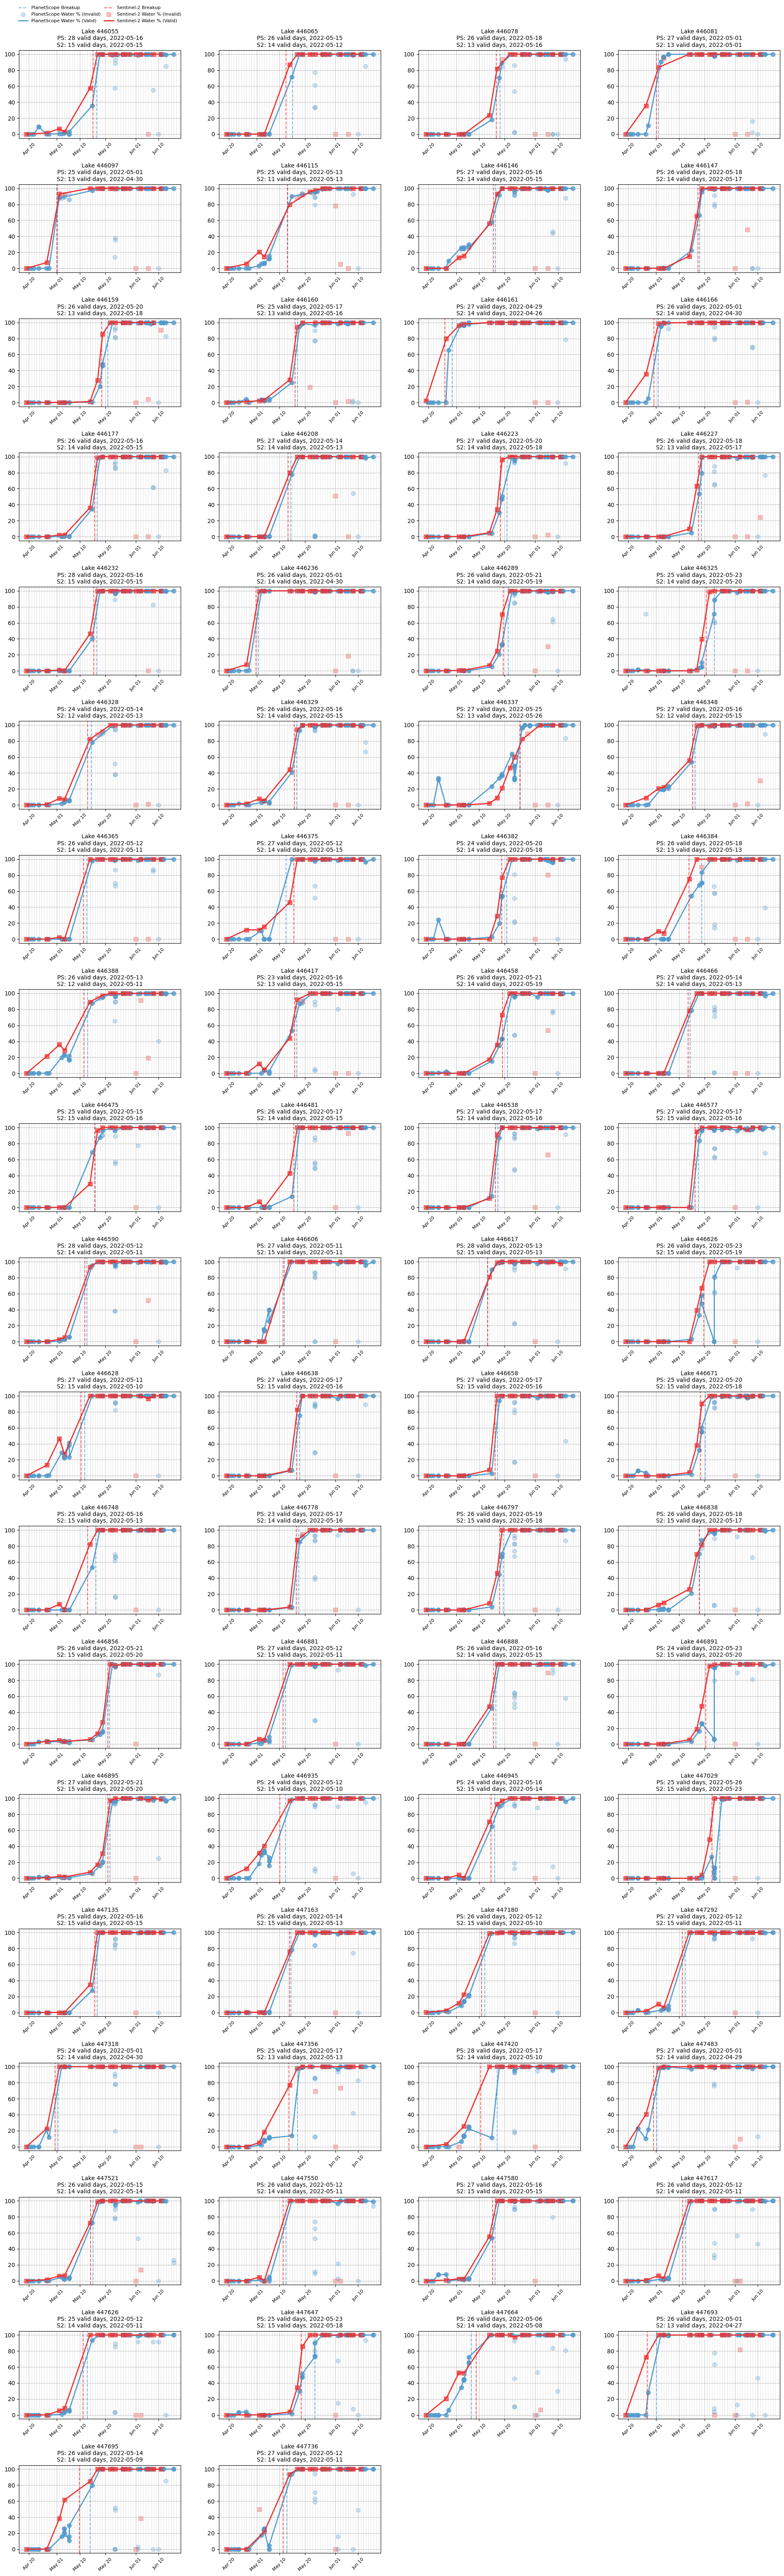

In [ ]:
""" Water Time Series for both Planet and S-2 """

ids = [446055,446065,446078,446081,446097,446115,446146,446147,446159,446160,446161,446166,446177,446208,446223,446227,446232,446236,446289,446325,446328,446329,446337,446348,446365,446375,446382,446384,446388,446417,446458,446466,446475,446481,446538,446577,446590,446606,446617,44662,446626,446628,446638,446658,446671,446748,446778,446797,446838,446856,446881,446888,446891,446895,446935,446945,447029,447135,447163,447180,447292,447318,447356,447420,447483,447521,447550,447580,447617,447626,447647,447664,447693,447695,447736]

# Paths
netcdf_path = r"D:\planetscope_lake_ice\Data\Output\lake_ice_time_series.nc"
sentinel_base_path = r"C:\Users\nj142\Desktop\2022 5x5km Sentinel-2 Time Series"
year = 2022

# Calculate aggregate stats only (no plotting)
stats = analyze_lakes(netcdf_path, lake_ids, year, sentinel_base_path, plot_individual=True)

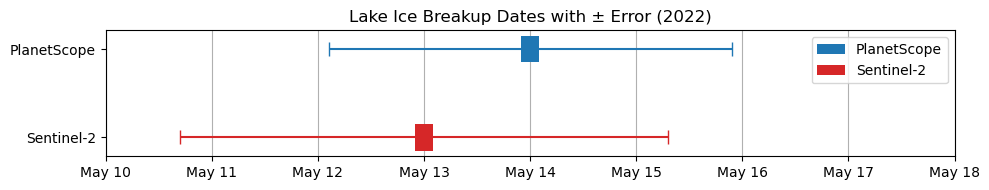

In [ ]:
""" Calendar Graph for both Planet and S-2 """

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Breakup date and error info
ps_date = datetime.strptime("2022-05-14", "%Y-%m-%d")
ps_error = 1.9
s2_date = datetime.strptime("2022-05-13", "%Y-%m-%d")
s2_error = 2.3

# Colors
ps_color = '#1f77b4'
s2_color = '#d62728'

# Time window
start_date = datetime.strptime("2022-05-10", "%Y-%m-%d")
end_date = datetime.strptime("2022-05-18", "%Y-%m-%d")

# Bar duration
bar_duration = timedelta(hours=4)
bar_offset = bar_duration / 2
bar_height = 0.3

# Plot
fig, ax = plt.subplots(figsize=(10, 2))

# Draw grid below
ax.grid(True, axis='x', zorder=1)

# Centered breakup bars (higher zorder)
ax.barh(y=1, width=bar_duration, left=ps_date - bar_offset, height=bar_height,
        color=ps_color, label="PlanetScope", zorder=3)
ax.barh(y=0, width=bar_duration, left=s2_date - bar_offset, height=bar_height,
        color=s2_color, label="Sentinel-2", zorder=3)

# Error bars (also above grid)
ax.errorbar(x=ps_date, y=1, xerr=timedelta(days=ps_error), fmt='o',
            color=ps_color, capsize=5, zorder=4)
ax.errorbar(x=s2_date, y=0, xerr=timedelta(days=s2_error), fmt='o',
            color=s2_color, capsize=5, zorder=4)

# Formatting
ax.set_yticks([0, 1])
ax.set_yticklabels(["Sentinel-2", "PlanetScope"])
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.set_title("Lake Ice Breakup Dates with ± Error (2022)")
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


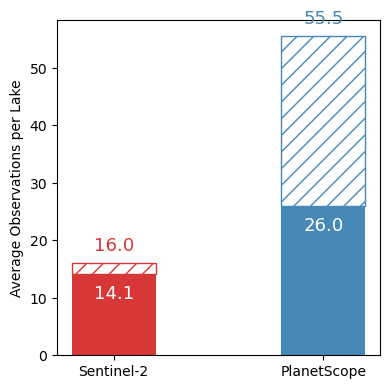

In [129]:
""" Valid Images for both Planet and S-2 """

import matplotlib.pyplot as plt

# Values
planet_valid = 26.0
planet_invalid = 29.5
sentinel_valid = 14.1
sentinel_invalid = 1.9

# Colors
planetscope_color = "#4688b6"
sentinel_color = "#d73737"

# Plot setup
fig, ax = plt.subplots(figsize=(4, 4))
bar_width = 0.4
x_pos = [0, 1]  # Sentinel-2 at 0, PlanetScope at 1
label_fontsize = 13

# Sentinel-2 bars
ax.bar(x_pos[0], sentinel_valid, width=bar_width, color=sentinel_color)
ax.bar(x_pos[0], sentinel_invalid, width=bar_width, bottom=sentinel_valid,
       color='none', edgecolor=sentinel_color, hatch='//')

# PlanetScope bars
ax.bar(x_pos[1], planet_valid, width=bar_width, color=planetscope_color)
ax.bar(x_pos[1], planet_invalid, width=bar_width, bottom=planet_valid,
       color='none', edgecolor=planetscope_color, hatch='//')

# Top value labels (totals) with matching colors
ax.text(x_pos[0], sentinel_valid + sentinel_invalid + 1.5,
        f"{sentinel_valid + sentinel_invalid:.1f}", ha='center', va='bottom',
        fontsize=label_fontsize, color=sentinel_color)

ax.text(x_pos[1], planet_valid + planet_invalid + 1.5,
        f"{planet_valid + planet_invalid:.1f}", ha='center', va='bottom',
        fontsize=label_fontsize, color=planetscope_color)

# Valid value labels (inside bars, white)
ax.text(x_pos[0], sentinel_valid - 5.0, f"{sentinel_valid:.1f}",
        ha='center', va='bottom', color='white', fontsize=label_fontsize)

ax.text(x_pos[1], planet_valid - 5.0, f"{planet_valid:.1f}",
        ha='center', va='bottom', color='white', fontsize=label_fontsize)

# Axis and layout settings
ax.set_xticks(x_pos)
ax.set_xticklabels(["Sentinel-2", "PlanetScope"])
ax.set_ylabel("Average Observations per Lake")
ax.set_title("")  # No title

plt.tight_layout()
plt.show()


In [ ]:
""" Calculate Sentinel-2 multi-year stats """
import pandas as pd
import os
from datetime import datetime, timedelta

# Folder path
folder_path = r"C:\Users\nj142\Desktop\2019-2025-S2"

# Helper to convert DOY to readable date (e.g., "May 15")
def doy_to_date_string(doy):
    try:
        base_date = datetime(2000, 1, 1)  # 2000 is a leap year, safe default
        date = base_date + timedelta(days=int(doy) - 1)
        return date.strftime("%b %d")  # e.g., "May 15"
    except:
        return None

# Results storage
yearly_stats = []

# Loop through each CSV file
for file_name in os.listdir(folder_path):
    if file_name.startswith("breakup_") and file_name.endswith(".csv"):
        year = file_name.split("_")[1]
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)

        # Convert breakup date string to datetime, then to DOY
        df["breakup_datetime"] = pd.to_datetime(df["breakup_date"], errors="coerce")
        df["breakup_doy"] = df["breakup_datetime"].dt.dayofyear

        # Calculate uncertainty and % valid
        df["uncertainty"] = (df["error_days_negative"] + df["error_days_positive"]) / 2
        df["valid_percent"] = (df["valid_observations"] / df["total_observations"]) * 100

        # Filter out invalid dates
        valid_rows = df[df["breakup_doy"].notnull()]

        # Compute metrics
        avg_breakup_doy = valid_rows["breakup_doy"].mean() if not valid_rows.empty else None
        avg_breakup_date_str = doy_to_date_string(avg_breakup_doy) if avg_breakup_doy else None
        avg_uncertainty = df["uncertainty"].mean()
        avg_valid_percent = df["valid_percent"].mean()

        yearly_stats.append({
            "year": year,
            "avg_breakup_date": avg_breakup_date_str,
            "avg_uncertainty_days": round(avg_uncertainty, 1),
            "avg_valid_percent": round(avg_valid_percent, 1)
        })

# Convert to DataFrame and show
summary_df = pd.DataFrame(yearly_stats).sort_values("year")
print("\nSummary:\n")
print(summary_df)


Processing images:  53%|█████▎    | 8/15 [00:03<00:02,  2.65it/s]

Error processing D:\planetscope_lake_ice\Data\Input\YKD\Breakup_2022\20220606_214615_49_248c_ortho_analytic_4b_sr.tif: Input shapes do not overlap raster.


Processing images: 100%|██████████| 15/15 [00:05<00:00,  2.76it/s]


GIF saved to D:\planetscope_lake_ice\Data\Output\Visualization GIFs\lake_165938_2022_timelapse.gif


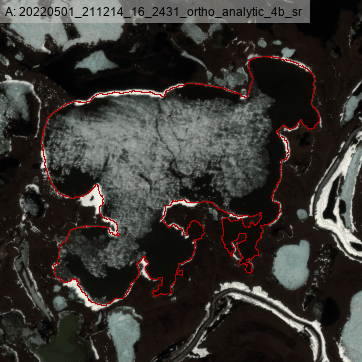

In [150]:
# GIF MAKING FUNCTION

def find_image_paths(base_dir, prefixes):
    """Find full paths for image files matching given prefixes."""
    
    matching_images = []
    
    for prefix in prefixes:
        search_pattern = os.path.join(base_dir, '**', f'{prefix}_ortho_analytic_4b_sr.tif')
        matches = glob.glob(search_pattern, recursive=True)
        
        if matches:
            matching_images.extend(matches)
        else:
            print(f"Warning: No image found for prefix {prefix}")
    
    return sorted(matching_images)

def get_lake_polygon(shapefile_path, lake_id):
    """Retrieve the polygon and CRS for a specific lake from ALPOD shapefile."""
    
    gdf = gpd.read_file(shapefile_path)
    lake_row = gdf[gdf['id'] == lake_id]
    
    if len(lake_row) == 0:
        print(f"No lake found with ID {lake_id}")
        return None, None
    
    return lake_row.geometry.iloc[0], lake_row.crs

def create_lake_bounds(lake_polygon, polygon_crs, src_crs):
    """
    Create a bounding box for the lake, transformed to the source CRS.
    
    Args:
        lake_polygon (shapely.geometry.Polygon): Lake polygon
        polygon_crs (pyproj.CRS): CRS of the original polygon
        src_crs (pyproj.CRS): Target CRS to transform to
    
    Returns:
        tuple: Bounding box coordinates (left, bottom, right, top)
    """
    
    # Create transformer
    transformer = Transformer.from_crs(polygon_crs, src_crs, always_xy=True)
    
    # Transform polygon coordinates
    transformed_coords = []
    for x, y in lake_polygon.exterior.coords:
        transformed_x, transformed_y = transformer.transform(x, y)
        transformed_coords.append((transformed_x, transformed_y))
    
    # Create a new polygon with transformed coordinates
    transformed_polygon = gpd.GeoSeries([shapely.geometry.Polygon(transformed_coords)], crs=src_crs)[0]
    
    # Get the geographic bounds
    left, bottom, right, top = transformed_polygon.bounds
    
    # Calculate the current width and height
    width = right - left
    height = top - bottom
    
    # Add 500m to sides 
    left -= 500
    right += 500
    bottom -= 500
    top += 500
    
    # Make it a square by taking the larger dimension
    square_size = max(right - left, top - bottom)
    
    # Center the square on the original bounds
    center_x = (left + right) / 2
    center_y = (bottom + top) / 2
    
    half_square = square_size / 2
    
    # Adjust bounds to create a square
    left = center_x - half_square
    right = center_x + half_square
    bottom = center_y - half_square
    top = center_y + half_square
    
    return (left, bottom, right, top)

def process_image(image_path, lake_bounds, lake_polygon=None, polygon_crs=None, downsample_factor=4, title=None):
    """
    Read, crop, and process a geotiff image with lake polygon overlay.
    """
    
    with rasterio.open(image_path) as src:
        # Crop to the lake bounds
        out_image, out_transform = rasterio.mask.mask(
            src, 
            [box(*lake_bounds)], 
            crop=True, 
            nodata=0
        )
        
        # Reorder bands from BGR NIR to RGB
        rgb_bands = out_image[[2, 1, 0]]  # Red, Green, Blue
        
        # Downsample
        downsampled_image = rgb_bands[:, ::downsample_factor, ::downsample_factor]
        
        # Transpose to (height, width, channels)
        downsampled_image = np.transpose(downsampled_image, (1, 2, 0))
        
        # Normalize to 0-255 range
        downsampled_image = ((downsampled_image - downsampled_image.min()) / 
                             (downsampled_image.max() - downsampled_image.min()) * 255).astype(np.uint8)
        
        # Convert to PIL Image for further processing
        pil_image = Image.fromarray(downsampled_image)  # Using PIL's Image directly
        draw = ImageDraw.Draw(pil_image, 'RGBA')
        
        # Overlay lake polygon if provided
        if lake_polygon is not None and polygon_crs is not None:
            try:
                # Transform polygon to image coordinates using the lake bounds transform
                transformer = Transformer.from_crs(polygon_crs, src.crs, always_xy=True)
                
                # Transform polygon coordinates
                transformed_coords = []
                for x, y in lake_polygon.exterior.coords:
                    # Transform geographic coordinates
                    transformed_x, transformed_y = transformer.transform(x, y)
                    
                    # Convert to pixel coordinates relative to the cropped image
                    pixel_x, pixel_y = ~out_transform * (transformed_x, transformed_y)
                    
                    # Downsample the coordinates
                    transformed_coords.append((
                        int(pixel_x / downsample_factor), 
                        int(pixel_y / downsample_factor)
                    ))
                
                # Darker, less saturated red with lower opacity
                red_outline_colors = [
                    (180, 0, 0, 200),  # Outer line - darker, less opaque
                    (180, 0, 0, 0),    # Middle line completely clear
                    (180, 0, 0, 200)   # Inner line - darker, less opaque
                ]
                
                # Draw thinner outlines
                for thickness, color in zip(range(3, 0, -1), red_outline_colors):
                    draw.polygon(transformed_coords, 
                                 outline=(*color[:3], color[3]), 
                                 fill=None)
                
            except Exception as e:
                print(f"Error transforming polygon: {e}")
        
        # Add title if provided
        if title:
            try:
                font = ImageFont.truetype("arial.ttf", 12)  # Reduced font size
            except IOError:
                font = ImageFont.load_default()
            
            # Add title with a semi-transparent background
            text_bbox = draw.textbbox((0, 0), title, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            
            draw.rectangle([0, 0, text_width + 10, text_height + 10], 
                           fill=(200, 200, 200, 128))
            
            draw.text((5, 5), title, font=font, fill=(0, 0, 0))
        
        return np.array(pil_image)

def get_lake_data_from_netcdf(netcdf_path, lake_id):
    """
    Get lake data from vlen NetCDF structure.
    
    Args:
        netcdf_path (str): Path to the NetCDF file
        lake_id (int): ID of the lake to process
    
    Returns:
        tuple: (prefixes_list, None)  
    """
    
    with nc.Dataset(netcdf_path, 'r') as ncfile:
        # Find the lake's index in the lake array
        lake_ids = ncfile.variables['lake_id'][:]
        try:
            lake_idx = np.where(lake_ids == lake_id)[0][0]
        except IndexError:
            print(f"Lake ID {lake_id} not found in the dataset.")
            return None, None
        
        # Get the count of observations for this lake
        obs_count = ncfile.variables['obs_count'][lake_idx]
        
        if obs_count == 0:
            print(f"No observations found for Lake ID {lake_id}")
            return [], None
        
        # For variable-length arrays, we directly access the arrays for the specific lake
        # Variable-length arrays are indexed by lake
        datetimes = ncfile.variables['unix_time'][lake_idx]  # This returns a numpy array
        
        # Handle prefix access - it's a comma-separated string for each lake
        prefix_raw = ncfile.variables['image_names_csv'][lake_idx]
        
        # Convert to string if needed
        if isinstance(prefix_raw, bytes):
            prefix_str = str(prefix_raw, 'utf-8')
        else:
            prefix_str = str(prefix_raw)
        
        # Split by commas to get individual prefixes
        prefixes = [p.strip() for p in prefix_str.split(',')]
        
        # Return just the prefixes and None for observation_data to match expected return values
        return prefixes, None

def generate_lake_gif(netcdf_path, lake_id, base_dir, output_dir, shapefile_path, year=2021, 
                     downsample_factor=4, display_gif=False):
    """
    Generate a GIF of lake images for a specific year with lake-centered zoom.
    Updated to work with ragged array NetCDF structure.
    
    Args:
        netcdf_path (str): Path to the ragged array NetCDF file
        lake_id (int): ID of the lake to process
        base_dir (str): Base directory for input images
        output_dir (str): Directory to save output GIF
        shapefile_path (str): Path to the lake shapefile
        year (int, optional): Year to process. Defaults to 2021.
        downsample_factor (int, optional): Factor to downsample images. Defaults to 4.
        display_gif (bool, optional): Whether to display the GIF. Defaults to False.
    
    Returns:
        str or None: Path to the generated GIF, or None if generation fails
    """
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Define the output path
    output_path = os.path.join(output_dir, f'lake_{lake_id}_{year}_timelapse.gif')
    
    # Check if GIF already exists
    if os.path.exists(output_path):
        print(f"GIF already exists at {output_path}. Skipping generation.")
        
        # Optional display
        if display_gif:
            try:
                from IPython.display import Image, display
                with open(output_path, 'rb') as f:
                    display(Image(data=f.read(), format='gif'))
            except ImportError:
                print("Cannot display GIF: Not in a Jupyter environment")
        
        return output_path
    
    # Get lake polygon and its CRS
    lake_polygon, polygon_crs = get_lake_polygon(shapefile_path, lake_id)
    
    if lake_polygon is None:
        print(f"Could not find polygon for Lake ID {lake_id}")
        return None
    
    # Get lake data using the vlen array approach
    prefixes, observation_data = get_lake_data_from_netcdf(netcdf_path, lake_id)
    
    if prefixes is None:
        print(f"Lake ID {lake_id} not found in the dataset.")
        return None
    
    if not prefixes:
        print(f"No prefixes found for Lake ID {lake_id}")
        return None
    
    # Filter prefixes for the specified year
    year_prefixes = [p for p in prefixes if str(year) in p]
    
    if not year_prefixes:
        print(f"No prefixes found for Lake ID {lake_id} in year {year}")
        return None
    
    # Find image paths and sort chronologically
    image_paths = find_image_paths(base_dir, year_prefixes)
    
    if not image_paths:
        print(f"No images found for Lake ID {lake_id} in year {year}")
        return None
    
    # Sort image paths chronologically
    image_paths.sort()
    
    # Prepare images for GIF
    images = []
    
    # Use the first image to get CRS for lake bounds
    with rasterio.open(image_paths[0]) as first_src:
        lake_bounds = create_lake_bounds(lake_polygon, polygon_crs, first_src.crs)
    
    for i, path in enumerate(tqdm(image_paths, desc="Processing images")):
        try:
            # Extract filename as title
            filename = os.path.splitext(os.path.basename(path))[0]
            
            # Add alphabetic label
            label = chr(65 + i)  # A, B, C, etc.
            title = f"{label}: {filename}"
            
            # Process image with lake bounds, polygon overlay, and title
            processed_image = process_image(
                path, lake_bounds, 
                lake_polygon=lake_polygon,
                polygon_crs=polygon_crs,
                downsample_factor=downsample_factor, 
                title=title
            )
            images.append(processed_image)
        except Exception as e:
            print(f"Error processing {path}: {e}")
    
    # Create GIF
    if images:
        imageio.mimsave(output_path, images, fps=2, loop=0)
        print(f"GIF saved to {output_path}")
        
        # Optional display
        if display_gif:
            try:
                from IPython.display import Image as IPythonImage, display
                with open(output_path, 'rb') as f:
                    display(IPythonImage(data=f.read(), format='gif'))
            except ImportError:
                print("Cannot display GIF: Not in a Jupyter environment")
        
        return output_path
    else:
        print("No images could be processed.")
        return None

# Example usage in __main__
if __name__ == "__main__":
    base_dir = r"D:\planetscope_lake_ice\Data\Input\YKD\Breakup_2022"
    output_dir = r"D:\planetscope_lake_ice\Data\Output\Visualization GIFs"
    shapefile_path = r"D:\planetscope_lake_ice\Break Up Training\8 - Download ALPOD data here\ALPODlakes.shp"
    netcdf_path = r"C:\Users\nj142\Desktop\lake_ice_time_series.nc"
    
    for id in ids: 
        # Generate GIF for lake ID
        generate_lake_gif(
            netcdf_path=netcdf_path,
            lake_id=id,
            base_dir=base_dir,
            output_dir=output_dir,
            shapefile_path=shapefile_path,
            year=2022,
            display_gif=True
        )

In [151]:
# VIDEO MAKING FUNCTION 

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, DayLocator
import netCDF4 as nc
import datetime
import cv2
from PIL import Image
import imageio
from tqdm import tqdm
from IPython.display import Video, display

def create_synchronized_lake_video(netcdf_path, lake_id, gif_folder, output_folder, year, 
                                 fps=3, figsize=(16, 6), point_size=100):
    """
    Create a synchronized video showing time series plot with highlighted points 
    and corresponding satellite images.
    
    Args:
        netcdf_path (str): Path to the NetCDF file
        lake_id (int): Lake ID to process
        gif_folder (str): Folder containing the GIF files
        output_folder (str): Folder to save output videos
        year (int): Year to process
        fps (int): Frames per second for output video
        figsize (tuple): Figure size for the plot
        point_size (int): Size of the highlighted point
    
    Returns:
        str or None: Path to generated video file, or None if failed
    """
    
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Check if GIF exists
    gif_path = os.path.join(gif_folder, f'lake_{lake_id}_{year}_timelapse.gif')
    if not os.path.exists(gif_path):
        print(f"GIF not found for Lake {lake_id} ({year}): {gif_path}")
        return None
    
    # Define output video path
    video_path = os.path.join(output_folder, f'lake_{lake_id}_{year}_synchronized.mp4')
    
    # Check if video already exists
    if os.path.exists(video_path):
        print(f"Video already exists: {video_path}")
        return video_path
    
    try:
        # Get time series data
        with nc.Dataset(netcdf_path, 'r') as ncfile:
            lake_ids = ncfile.variables['lake_id'][:]
            
            try:
                lake_index = list(lake_ids).index(lake_id)
            except ValueError:
                print(f"Lake ID {lake_id} not found in dataset")
                return None
            
            # Check if lake has observations
            obs_count = ncfile.variables['obs_count'][lake_index]
            if obs_count == 0:
                print(f"Lake {lake_id} has no observations")
                return None
            
            # Extract time series data
            time_data = ncfile.variables['unix_time'][lake_index]
            datetimes = [datetime.datetime.fromtimestamp(ts) for ts in time_data]
            ice_percent = ncfile.variables['ice_percent'][lake_index]
            snow_percent = ncfile.variables['snow_percent'][lake_index]
            water_percent = ncfile.variables['water_percent'][lake_index]
            
            # Create dataframe
            df_full = pd.DataFrame({
                'datetime': datetimes,
                'ice_percent': ice_percent,
                'snow_percent': snow_percent,
                'water_percent': water_percent
            })
            
            # Filter for specified year and months (April-June)
            df_full['year'] = df_full['datetime'].dt.year
            df_full['month'] = df_full['datetime'].dt.month
            df_year = df_full[(df_full['year'] == year) & (df_full['month'].between(4, 6))].copy()
            
            if df_year.empty:
                print(f"No data found for Lake {lake_id} in year {year} (April-June)")
                return None
            
            # Sort by datetime
            df_year = df_year.sort_values('datetime').reset_index(drop=True)
            
            # Get daily aggregated data (using your existing function)
            df_daily = aggregate_daily_observations(df_year)
            df_classified = classify_pixel_validity(df_daily)
            
            # Find breakup date
            breakup_date, days_before, days_after, detection_method = find_breakup_date(df_year)
            
            # Separate valid and invalid points
            valid_points = df_classified[df_classified['pixel_valid']]
            invalid_points = df_classified[~df_classified['pixel_valid']]
    
    except Exception as e:
        print(f"Error reading NetCDF data for Lake {lake_id}: {e}")
        return None
    
    # Load GIF frames and get corresponding dates
    try:
        gif_frames = imageio.mimread(gif_path)
        print(f"Loaded {len(gif_frames)} frames from GIF")
        
        # Get the image prefixes/dates for the GIF frames
        prefixes, _ = get_lake_data_from_netcdf(netcdf_path, lake_id)
        if prefixes is None:
            print(f"Could not get image prefixes for Lake {lake_id}")
            return None
        
        # Filter prefixes for the specified year
        year_prefixes = [p for p in prefixes if str(year) in p]
        
        # Extract dates from prefixes (assuming format like "20220415_123456_abcd")
        gif_dates = []
        for prefix in year_prefixes:
            try:
                # Extract date part (first 8 characters should be YYYYMMDD)
                date_str = prefix[:8]
                gif_date = datetime.datetime.strptime(date_str, '%Y%m%d').date()
                gif_dates.append(gif_date)
            except (ValueError, IndexError):
                print(f"Could not parse date from prefix: {prefix}")
                gif_dates.append(None)
        
        # Create mapping of dates to GIF frames
        gif_date_to_frame = {}
        for i, (gif_date, frame) in enumerate(zip(gif_dates, gif_frames)):
            if gif_date is not None:
                gif_date_to_frame[gif_date] = frame
        
        print(f"Successfully mapped {len(gif_date_to_frame)} GIF frames to dates")
        
    except Exception as e:
        print(f"Error loading GIF and mapping dates: {e}")
        return None
    
    # Define colors
    ice_color = '#87CEEB'
    snow_color = '#FF8C00'
    water_color = '#0000FF'
    highlight_color = '#FF0000'
    
    # Create video writer
    temp_video_path = video_path.replace('.mp4', '_temp.mp4')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    # Calculate video dimensions (plot + image side by side)
    plot_width = int(figsize[0] * 100)  # Convert to pixels
    plot_height = int(figsize[1] * 100)
    
    # Get image dimensions from first GIF frame
    img_height, img_width = gif_frames[0].shape[:2]
    
    # Scale image to match plot height
    scale_factor = plot_height / img_height
    scaled_img_width = int(img_width * scale_factor)
    scaled_img_height = plot_height
    
    total_width = plot_width + scaled_img_width
    
    out = cv2.VideoWriter(temp_video_path, fourcc, fps, (total_width, plot_height))
    
    # Create frames only for dates that exist in both chart data and GIF
    chart_dates = [row['datetime'].date() for _, row in df_classified.iterrows()]
    common_dates = sorted(set(chart_dates) & set(gif_date_to_frame.keys()))
    
    if not common_dates:
        print(f"No common dates found between chart data and GIF frames")
        return None
    
    print(f"Found {len(common_dates)} common dates for synchronization")
    
    # Filter chart data to only include common dates
    df_sync = df_classified[df_classified['datetime'].dt.date.isin(common_dates)].copy()
    df_sync = df_sync.sort_values('datetime').reset_index(drop=True)
    
    print(f"Creating video with {len(df_sync)} synchronized frames...")
    
    # Create frames
    for i, (idx, row) in enumerate(tqdm(df_sync.iterrows(), total=len(df_sync), desc="Creating video frames")):
        current_date = row['datetime'].date()
        
        # Get corresponding GIF frame
        gif_frame = gif_date_to_frame[current_date]
        plt.figure(figsize=figsize, dpi=100)
        ax = plt.gca()
        
        # Plot all data points (lines and scatter)
        if not valid_points.empty:
            ax.plot(valid_points['datetime'], valid_points['water_percent'],
                   label='Water %', color=water_color, alpha=0.7)
            ax.plot(valid_points['datetime'], valid_points['ice_percent'],
                   label='Ice %', color=ice_color, alpha=0.7)
            ax.plot(valid_points['datetime'], valid_points['snow_percent'],
                   label='Snow %', color=snow_color, alpha=0.7)
            
            # Regular scatter points
            ax.scatter(valid_points['datetime'], valid_points['water_percent'], 
                      color=water_color, marker='o', alpha=0.7, s=30)
            ax.scatter(valid_points['datetime'], valid_points['ice_percent'], 
                      color=ice_color, marker='o', alpha=0.7, s=30)
            ax.scatter(valid_points['datetime'], valid_points['snow_percent'], 
                      color=snow_color, marker='o', alpha=0.7, s=30)
        
        # Plot invalid points
        if not invalid_points.empty:
            ax.scatter(invalid_points['datetime'], invalid_points['water_percent'], 
                      color=water_color, marker='o', alpha=0.7, s=30)
            ax.scatter(invalid_points['datetime'], invalid_points['ice_percent'], 
                      color=ice_color, marker='o', alpha=0.7, s=30)
            ax.scatter(invalid_points['datetime'], invalid_points['snow_percent'], 
                      color=snow_color, marker='o', alpha=0.7, s=30)
        
        # Highlight current point with larger red dots
        current_datetime = row['datetime']
        ax.scatter(current_datetime, row['water_percent'], 
                  color=highlight_color, marker='o', s=point_size, alpha=0.8, zorder=10)
        ax.scatter(current_datetime, row['ice_percent'], 
                  color=highlight_color, marker='o', s=point_size, alpha=0.8, zorder=10)
        ax.scatter(current_datetime, row['snow_percent'], 
                  color=highlight_color, marker='o', s=point_size, alpha=0.8, zorder=10)
        
        # Plot breakup date
        if breakup_date is not None:
            ax.axvline(x=breakup_date, color='red', linestyle='--', alpha=0.7, label='Breakup')
        
        # Format plot
        if breakup_date is not None:
            breakup_str = breakup_date.strftime('%Y-%m-%d')
            title = f"Lake {lake_id} ({year}) | Breakup: {breakup_str} +{days_after}/-{days_before} ({detection_method})"
        else:
            title = f"Lake {lake_id} ({year}) | No breakup detected ({detection_method})"
        
        # Add current date to title
        current_date_str = current_datetime.strftime('%Y-%m-%d')
        title += f" | Current: {current_date_str}"
        
        ax.set_title(title, fontsize=10)
        ax.set_xlabel("Date")
        ax.set_ylabel("Percentage")
        ax.legend()
        ax.grid(True)
        
        # Format x-axis
        ax.xaxis.set_major_locator(DayLocator(bymonthday=[1, 10, 20]))
        ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
        ax.xaxis.set_minor_locator(DayLocator())
        ax.tick_params(axis='x', which='major', rotation=45, labelsize=8)
        ax.tick_params(axis='x', which='minor', length=0)
        ax.grid(True, which='major', linestyle='-', linewidth=0.8)
        ax.grid(True, which='minor', linestyle=':', linewidth=0.5, color='gray')
        
        plt.tight_layout()
        
        # Convert plot to image
        plt.savefig('temp_plot.png', dpi=100, bbox_inches='tight')
        plt.close()
        
        plot_img = cv2.imread('temp_plot.png')
        plot_img = cv2.resize(plot_img, (plot_width, plot_height))
        
        # Process GIF frame
        if len(gif_frame.shape) == 3:
            gif_frame = cv2.cvtColor(gif_frame, cv2.COLOR_RGB2BGR)
        gif_frame = cv2.resize(gif_frame, (scaled_img_width, scaled_img_height))
        
        # Combine plot and image horizontally
        combined_frame = np.hstack([plot_img, gif_frame])
        
        # Write frame to video
        out.write(combined_frame)
    
    # Clean up
    out.release()
    if os.path.exists('temp_plot.png'):
        os.remove('temp_plot.png')
    
    # Convert to proper MP4 format
    temp_reader = cv2.VideoCapture(temp_video_path)
    fourcc = cv2.VideoWriter_fourcc(*'H264')
    final_out = cv2.VideoWriter(video_path, fourcc, fps, (total_width, plot_height))
    
    while True:
        ret, frame = temp_reader.read()
        if not ret:
            break
        final_out.write(frame)
    
    temp_reader.release()
    final_out.release()
    
    # Remove temporary file
    os.remove(temp_video_path)
    
    print(f"Video saved to: {video_path}")
    return video_path

def process_lake_list(netcdf_path, lake_ids, gif_folder, output_folder, year, 
                     fps=3, display_videos=True):
    """
    Process a list of lake IDs and create synchronized videos.
    
    Args:
        netcdf_path (str): Path to the NetCDF file
        lake_ids (list): List of lake IDs to process
        gif_folder (str): Folder containing GIF files
        output_folder (str): Folder to save output videos
        year (int): Year to process
        fps (int): Frames per second for videos
        display_videos (bool): Whether to display videos in Jupyter
    
    Returns:
        dict: Dictionary mapping lake_id to video_path (or None if failed)
    """
    
    results = {}
    
    for lake_id in lake_ids:
        print(f"\n{'='*50}")
        print(f"Processing Lake ID: {lake_id}")
        print(f"{'='*50}")
        
        video_path = create_synchronized_lake_video(
            netcdf_path=netcdf_path,
            lake_id=lake_id,
            gif_folder=gif_folder,
            output_folder=output_folder,
            year=year,
            fps=fps
        )
        
        results[lake_id] = video_path
        
        # Display video if requested and successfully created
        if display_videos and video_path and os.path.exists(video_path):
            print(f"Displaying video for Lake {lake_id}:")
            display(Video(video_path, width=800))
    
    return results

# Example usage
if __name__ == "__main__":
    # Configuration
    netcdf_path = r"C:\Users\nj142\Desktop\lake_ice_time_series.nc"
    gif_folder = r"D:\planetscope_lake_ice\Data\Output\Visualization GIFs"
    output_folder = r"D:\planetscope_lake_ice\Data\Output\Synchronized Videos"
    year = 2022
    
    # Process all lakes
    results = process_lake_list(
        netcdf_path=netcdf_path,
        lake_ids=ids,
        gif_folder=gif_folder,
        output_folder=output_folder,
        year=year,
        fps=3,
        display_videos=True
    )
    
    # Print summary
    print(f"\n{'='*50}")
    print("PROCESSING SUMMARY")
    print(f"{'='*50}")
    
    successful = 0
    failed = 0
    
    for lake_id, video_path in results.items():
        if video_path:
            print(f"Lake {lake_id}: SUCCESS - {video_path}")
            successful += 1
        else:
            print(f"Lake {lake_id}: FAILED")
            failed += 1
    
    print(f"\nTotal: {len(lake_ids)} lakes")
    print(f"Successful: {successful}")
    print(f"Failed: {failed}")


Processing Lake ID: 165938
Loaded 14 frames from GIF
Successfully mapped 10 GIF frames to dates
Found 10 common dates for synchronization
Creating video with 10 synchronized frames...


Creating video frames: 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]


Video saved to: D:\planetscope_lake_ice\Data\Output\Synchronized Videos\lake_165938_2022_synchronized.mp4
Displaying video for Lake 165938:



PROCESSING SUMMARY
Lake 165938: SUCCESS - D:\planetscope_lake_ice\Data\Output\Synchronized Videos\lake_165938_2022_synchronized.mp4

Total: 0 lakes
Successful: 1
Failed: 0
